# Aviso
Se você está procurando pelo contexto, resultados ou talvez a estratégia de resolução usada aqui para este problema em questão, você deve ler o arquivo **README.md** deste projeto, que se encontra no seguinte endereço: [rossmann-previsao-de-vendas](https://github.com/cenciati/portfolio/tree/main/rossmann-previsao-de-vendas). Lá você não só encontrará tudo relacionado a parte não técnica do projeto, mas também toda a explicação por trás das decisões técnicas tomadas.

*Desde já agradeço!*

# 0. Imports

## 0.1. Bibliotecas

In [1]:
# manipulação de dados
import pandas as pd
from inflection import underscore
import numpy as np

# visualziação de dados
from matplotlib import pyplot as plt
import seaborn as sns

# machine learning
from sklearn import preprocessing as pp
from sklearn import metrics as m
from sklearn import model_selection as ms
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMRegressor

# outros
import datetime
from IPython.display import Image
import joblib

# meu arquivo python com funções que sempre uso
import os
import sys
sys.path.append('../src')
from mytoolbox import MyToolBox

## instanciando uma variável com a classes
mtb = MyToolBox()

## setando configurações personalizadas pro arquivo 'ipynb'
mtb.jupyter_settings()

Done!


c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.2. Funções auxiliares

In [2]:
def model_performance(model_name, y_true, y_pred):
    """Evaluate a trained machine learning model.

    Parameters
    ----------
    model_name : string
        The name of the model used.
    y_true : pandas series
        True results.
    y_pred : pandas series
        Predicted results.
    
    Returns
    -------
    pandas dataframe
    """
    # calculate metrics
    mae = m.mean_absolute_error(y_true, y_pred)
    mape = m.mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(m.mean_squared_error(y_true, y_pred))
    
    # results
    df = pd.DataFrame({'Model name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index=[0])
    
    return df


def cross_validation(kfold, estimator, x, verbose=False):
    """Evaluate a model by cross-validation.

    Parameters
    ----------
    kfold : int
        Determines the cross-validation splitting strategy.
    estimator : object
        Determines the algorithm to be used.
    x : pandas dataframe
        The data to fit and evaluate.
    verbose : boolean, default=False
        The verbosity level.
    
    Returns
    -------
    pandas dataframe
    """
    # define metrics lists
    mae_list, mape_list, rmse_list = [], [], []
    
    # cross validation
    for k in reversed(range(1, kfold+1)):
        # verbosity
        if verbose:
            print(f'Fold number: {k}\n')
        
        # define start and end date for validation
        validation_start_date = x['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering data set
        training = x[x['date'] < validation_start_date]
        validation = x[(x['date'] >= validation_start_date) & (x['date'] <= validation_end_date)]    

        # prepare data sets
        x_train = training.drop(['date', 'sales'], axis=1)
        y_train = training['sales']

        x_val = validation.drop(['date', 'sales'], axis=1)
        y_val = validation['sales']

        # instantiate and fit the model
        model = estimator.fit(x_train, y_train)

        # predict
        yhat = model.predict(x_val)

        # metrics
        metrics = model_performance(model_name=str(estimator).split('(')[0],
                                    y_true=y_val, y_pred=yhat)
        
        # store performances
        mae_list.append(metrics['MAE'])
        mape_list.append(metrics['MAPE'])
        rmse_list.append(metrics['RMSE'])
    
    # result
    results = {'Model name': metrics['Model name'],
               'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
               'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
               'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}

    return pd.DataFrame(results, index=[0])


## 0.3. Aquisição dos dados
Fonte dos dados: [Kaggle](https://www.kaggle.com/c/rossmann-store-sales)

In [3]:
# leitura dos dados em formato .csv
df_raw_vendas = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_raw_lojas = pd.read_csv('../data/raw/store.csv', low_memory=False)

# juntando as tabelas com uma coluna pivô
df_raw = pd.merge(df_raw_vendas, df_raw_lojas, how='left', on='Store')

In [4]:
# visualizando uma amostra de cinco linhas aleatórias da tabela
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
76435,616,7,2015-05-24,0,0,0,0,0,0,a,c,3040.000,8.000,2011.000,1,35.000,2010.000,"Mar,Jun,Sept,Dec"
923026,592,2,2013-03-26,5548,710,1,1,0,1,a,a,2540.000,6.000,2005.000,0,NaN,NaN,NaN
731180,526,6,2013-09-14,7467,1150,1,0,0,0,a,a,120.000,NaN,NaN,1,48.000,2011.000,"Mar,Jun,Sept,Dec"
790350,601,2,2013-07-23,3360,323,1,0,0,1,d,a,8220.000,4.000,2014.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
252134,953,1,2014-12-15,11414,853,1,1,0,0,a,a,19830.000,4.000,2006.000,1,22.000,2011.000,"Mar,Jun,Sept,Dec"


# 1. Limpeza e descrição estatística dos dados

## 1.1. Renomear colunas

In [5]:
# renomeando todas as colunas dos dados para o formato snakecase
df_raw.columns = [underscore(coluna) for coluna in df_raw.columns]

# checando
df_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Index

coluna | descrição
-------|----------
'store' | identificador único para cada loja
'day_of_week' | dia da semana
'date' | data
'open' | indicador de se a loja estava aberta ou fechada, sendo 0 = fecahda ou 1 = aberta
'promo' | indicador de se a loja estava com promoção naquele dia
'state_holiday' | indica estado de feriado, sendo a = feriado público, b = páscoa, c = natal, 0 = nenhum
'school_holiday' | indica se a loja em tal data foi aplicado pelo fechamento de escolas públicas
'store_type' | tipo da loja , podendo ser a, b, c ou d
'assortment' | descreve o nível de varieadade do estoque, podendo ser a = básico, b = extra, c = extendido
'competition_distance', | distância em metros do competidor mais próximo
'competition_open_since_month' | mês aproximado da abertuda da loja do competidor mais próximo
'competition_open_since_year' | ano aproximado da abertuda da loja do competidor mais próximo
'promo2' | a continuação de uma promoção consecutiva, podendo ser 0 = não participando ou 1 = participando
'promo2_since_week' | semana que a loja começou a promoção extendida
'promo2_since_year' | ano que a loja começou a promoção extendida
'promo_interval' | indicação dos meses que a promoção ficou ativa

## 1.2. Dimensões dos dados

In [6]:
# checando a proporção dos dados
print('Número de linhas: {:,}\nNúmero de colunas {:,}'.format(df_raw.shape[0], df_raw.shape[1]))

Número de linhas: 1,017,209
Número de colunas 18


## 1.3. Dados duplicados

In [7]:
# checando se há entradas duplicadas nos dados
df_raw.duplicated().sum()

0

## 1.4. Tipo dos dados

In [8]:
# checando o tipo de dado de cada coluna e o uso de memória
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [9]:
# alterando os tipos que julgo necessário
## transformando colunas para o tipo 'category'
colunas_para_category = ['store', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'promo2']
df_raw[colunas_para_category]= df_raw[colunas_para_category].apply(lambda coluna: coluna.astype('category'))

## transformando colunas para o tipo 'datetime'
df_raw['date'] = pd.to_datetime(df_raw['date'])

In [10]:
# checando o novo uso de memória do conjunto de dados
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  category      
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  category      
 6   promo                         1017209 non-null  category      
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  category      
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

## 1.5. Dados faltantes

In [11]:
# checando a porcentagem de dados nulos por coluna
(df_raw.isna().sum() / len(df_raw)).sort_values(ascending=False)

promo_interval                 0.499
promo2_since_year              0.499
promo2_since_week              0.499
competition_open_since_year    0.318
competition_open_since_month   0.318
competition_distance           0.003
day_of_week                    0.000
promo2                         0.000
assortment                     0.000
store                          0.000
school_holiday                 0.000
state_holiday                  0.000
promo                          0.000
open                           0.000
customers                      0.000
sales                          0.000
date                           0.000
store_type                     0.000
dtype: float64

In [12]:
# tratamento dos dados faltantes
## competition_distance
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x: 200_000.0 if pd.isna(x) else x)

## competition_open_since_month
df_raw['competition_open_since_month'] = df_raw.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

## competition_open_since_year
df_raw['competition_open_since_year'] = df_raw.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

## promo2_since_week
df_raw['promo2_since_week'] = df_raw.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

## promo2_since_year
df_raw['promo2_since_year'] = df_raw.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

## promo_interval
df_raw['promo_interval'].fillna(0, inplace=True)

### criando a coluna 'is_promo' e tratando os zeros preenchidos na coluna 'promo_interval'
dic_month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_raw['month_map'] = df_raw['date'].dt.month.map(dic_month_map)
df_raw['is_promo'] = df_raw[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
# checando as modificações
df_raw.sample(5).T

,860684,503976,160674,170420,346504
store,690,782,115,941,873
day_of_week,2,7,1,7,5
date,2013-05-21 00:00:00,2014-04-06 00:00:00,2015-03-09 00:00:00,2015-03-01 00:00:00,2014-09-05 00:00:00
sales,5716,0,6855,0,3903
customers,838,0,457,0,464
open,1,0,1,0,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,c,d,a,a


In [14]:
# fazendo as últimas transformações nas colunas, agora sem valores nulos
colunas_para_int = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']
df_raw[colunas_para_int]= df_raw[colunas_para_int].apply(lambda coluna: coluna.astype('int64'))

## 1.6. Outliers

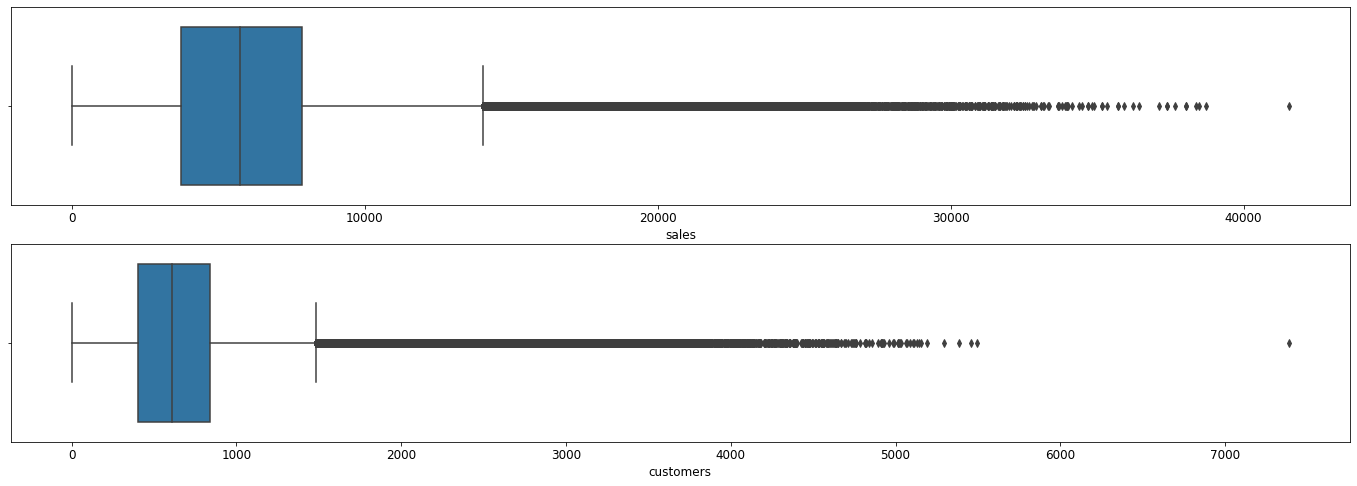

In [15]:
# definindo área e formato dos gráficos
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(24,8))
(ax1, ax2) = ax

# plotagem dos gráficos
sns.boxplot(x=df_raw['sales'], ax=ax1);
sns.boxplot(x=df_raw['customers'], ax=ax2);

In [16]:
# quantidade de entradas nos dados antes do tratamento de outliers
print('Quantidade de linhas antes do tratamento: {:,}'.format(len(df_raw)))

# checando outliers
for coluna in ['sales', 'customers']:
    ## definindo o que são outliers para esse projeto
    cut_off = 3 * (np.std(df_raw[coluna])) # nossa linha de corte será 3 vezes o desvio padrão da coluna em questão
    lower, upper = (np.mean(df_raw[coluna]) - cut_off), (np.mean(df_raw[coluna]) + cut_off) # definindo ponto máximo e mínimo (média +/- linha de corte)

    ## identificando os outliers dado a nossa definição anterior
    mascara_outliers = [False if (x < lower) or (x > upper) else True for x in df_raw[coluna]]
    df_raw = df_raw.loc[mascara_outliers]

# quantidade de entradas que sobraram depois do tratamento de outliers
print('Quantidade de linhas depois do tratamento: {:,}'.format(len(df_raw)))

Quantidade de linhas antes do tratamento: 1,017,209
Quantidade de linhas depois do tratamento: 996,977


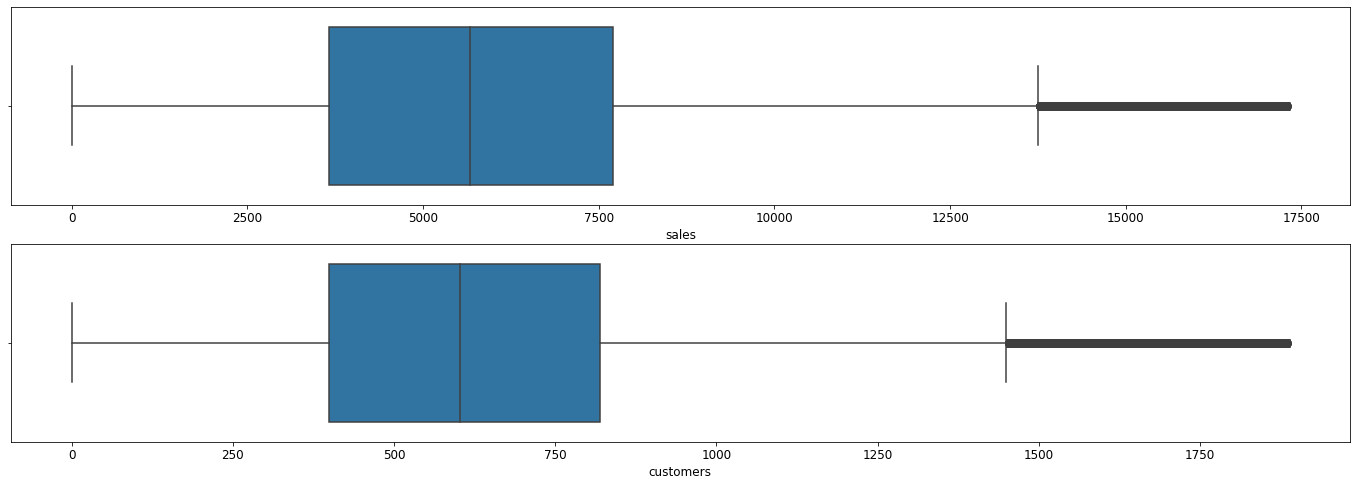

In [17]:
# definindo área e formato dos gráficos
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(24,8))
(ax1, ax2) = ax

# resultado visual do tratamento de outliers
sns.boxplot(x=df_raw['sales'], ax=ax1);
sns.boxplot(x=df_raw['customers'], ax=ax2);

## 1.7. Estatísticas descritivas

In [18]:
# somente as colunas numéricas
df_atrib_numericos = df_raw.select_dtypes(include=['int64', 'float64'])

# somente as colunas categóricas
df_atrib_categoricos = df_raw.select_dtypes(include=['category'])

### 1.7.1. Atributos numéricos

In [19]:
# tabela com a tendência central e dispersão dos dados
df_estatistica_descritiva = pd.DataFrame({'média': df_atrib_numericos.apply(np.mean),
                                          'mediana': df_atrib_numericos.apply(np.median),
                                          'desvio padrão': df_atrib_numericos.apply(np.std),
                                          'mín': df_atrib_numericos.apply(min),
                                          'máx': df_atrib_numericos.apply(max),
                                          'range': df_atrib_numericos.apply(lambda x: x.max() - x.min()),
                                          'skew': df_atrib_numericos.apply(lambda x: x.skew()),
                                          'kurtosis': df_atrib_numericos.apply(lambda x: x.kurtosis())})

# visualizar a tabela criada
df_estatistica_descritiva

,média,mediana,desvio padrão,mín,máx,range,skew,kurtosis
day_of_week,4.011,4.000,1.997,1.000,7.000,6.000,-0.004,-1.246
sales,5549.279,5673.000,3491.715,0.000,17323.000,17323.000,0.102,-0.167
customers,596.791,602.000,380.725,0.000,1888.000,1888.000,0.225,0.092
competition_distance,6023.361,2410.000,12638.030,20.000,200000.000,199980.000,10.190,145.977
competition_open_since_month,6.792,7.000,3.312,1.000,12.000,11.000,-0.044,-1.233
competition_open_since_year,2010.321,2012.000,5.531,1900.000,2015.000,115.000,-7.305,125.145
promo2_since_week,23.547,22.000,14.284,1.000,52.000,51.000,0.181,-1.185
promo2_since_year,2012.781,2013.000,1.667,2009.000,2015.000,6.000,-0.775,-0.236
is_promo,0.168,0.000,0.374,0.000,1.000,1.000,1.776,1.154


### 1.7.2. Atributos categóricos

In [20]:
# tabela com a descrição dos dados categóricos
df_estatistica_descritiva = df_atrib_categoricos.describe().T

# visualizar a tabela criada
df_estatistica_descritiva

,count,unique,top,freq
store,996977,1114,1,942
open,996977,2,1,824160
promo,996977,2,0,620160
state_holiday,996977,4,0,966152
school_holiday,996977,2,0,819440
store_type,996977,4,a,541173
assortment,996977,3,a,530396
promo2,996977,2,1,504957


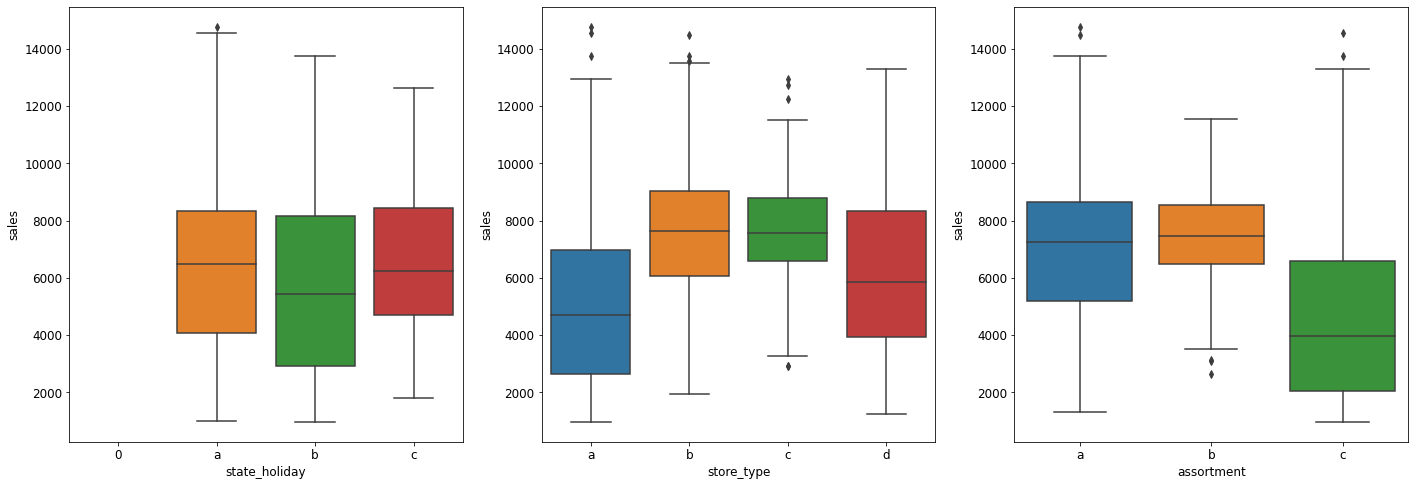

In [21]:
# definindo área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
(ax1, ax2, ax3) = ax

# criando variável com o conjunto de dados filtrado
auxiliar = df_raw[(df_raw['state_holiday'] != '0') & (df_raw['sales'] > 0)]

# plotagem dos gráficos
sns.boxplot(x='state_holiday', y='sales', data=auxiliar, ax=ax1);
sns.boxplot(x='store_type', y='sales', data=auxiliar, ax=ax2);
sns.boxplot(x='assortment', y='sales', data=auxiliar, ax=ax3);

# 2. Engenharia de features

## 2.1. Modelagem do fenômeno

In [22]:
# ano
df_raw['year'] = df_raw['date'].dt.year

# mês
df_raw['month'] = df_raw['date'].dt.month

# dia
df_raw['day'] = df_raw['date'].dt.day

# semana do ano
df_raw['week_of_year'] = df_raw['date'].dt.weekofyear

# ano semana
df_raw['year_week'] = df_raw['date'].dt.strftime('%Y-%W')

C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\4087718585.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_raw['week_of_year'] = df_raw['date'].dt.weekofyear


In [23]:
# competição desde
df_raw['competition_since'] = df_raw.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df_raw['competition_time_month'] = ((df_raw['date'] - df_raw['competition_since']) / 30).apply(lambda x: x.days).astype('int64')

# promoção desde
df_raw['promo_since'] = df_raw['promo2_since_year'].astype(str) + '-' + df_raw['promo2_since_week'].astype(str)
df_raw['promo_since'] = df_raw['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_raw['promo_time_week'] = ((df_raw['date'] - df_raw['promo_since']) / 7).apply(lambda x: x.days).astype('int64')

In [24]:
# renomeando as categorias da coluna 'assortment'
df_raw['assortment'] = df_raw['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# renomeando as categorias da coluna 'state_holiday'
df_raw['state_holiday'] = df_raw['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c'else 'regular_day')

## 2.2. Filtragem

In [25]:
# filtrando as linhas para que só hajam lojas abertas e com vendas realizadas no conjunto
df_raw = df_raw[(df_raw['open'] != 0) & (df_raw['sales'] > 0)]

# definindo colunas para dropar
colunas_dropar = ['customers', 'open', 'promo_interval', 'month_map']

# excluindo colunas definidas como redundantes que só aumentam a dimensionalidade do problema
df_raw.drop(colunas_dropar, axis=1, inplace=True)

## Checkpoint

In [26]:
# a fim de usufruir da melhor maneira a memória da máquina e ainda sim não precisar
# ficar rodando todo o notebook optarei por serializar os dados e carregá-los novamente nessa etapa
joblib.dump(df_raw, '../data/interim/df_teste.pkl')

# carregando conjunto de dados serialziado
df = joblib.load('../data/interim/df_teste.pkl')

# excluindo o conjunto atual que está carregado em memória
del df_raw

# 3. Análise exploratória de dados

## Mapa mental do problema

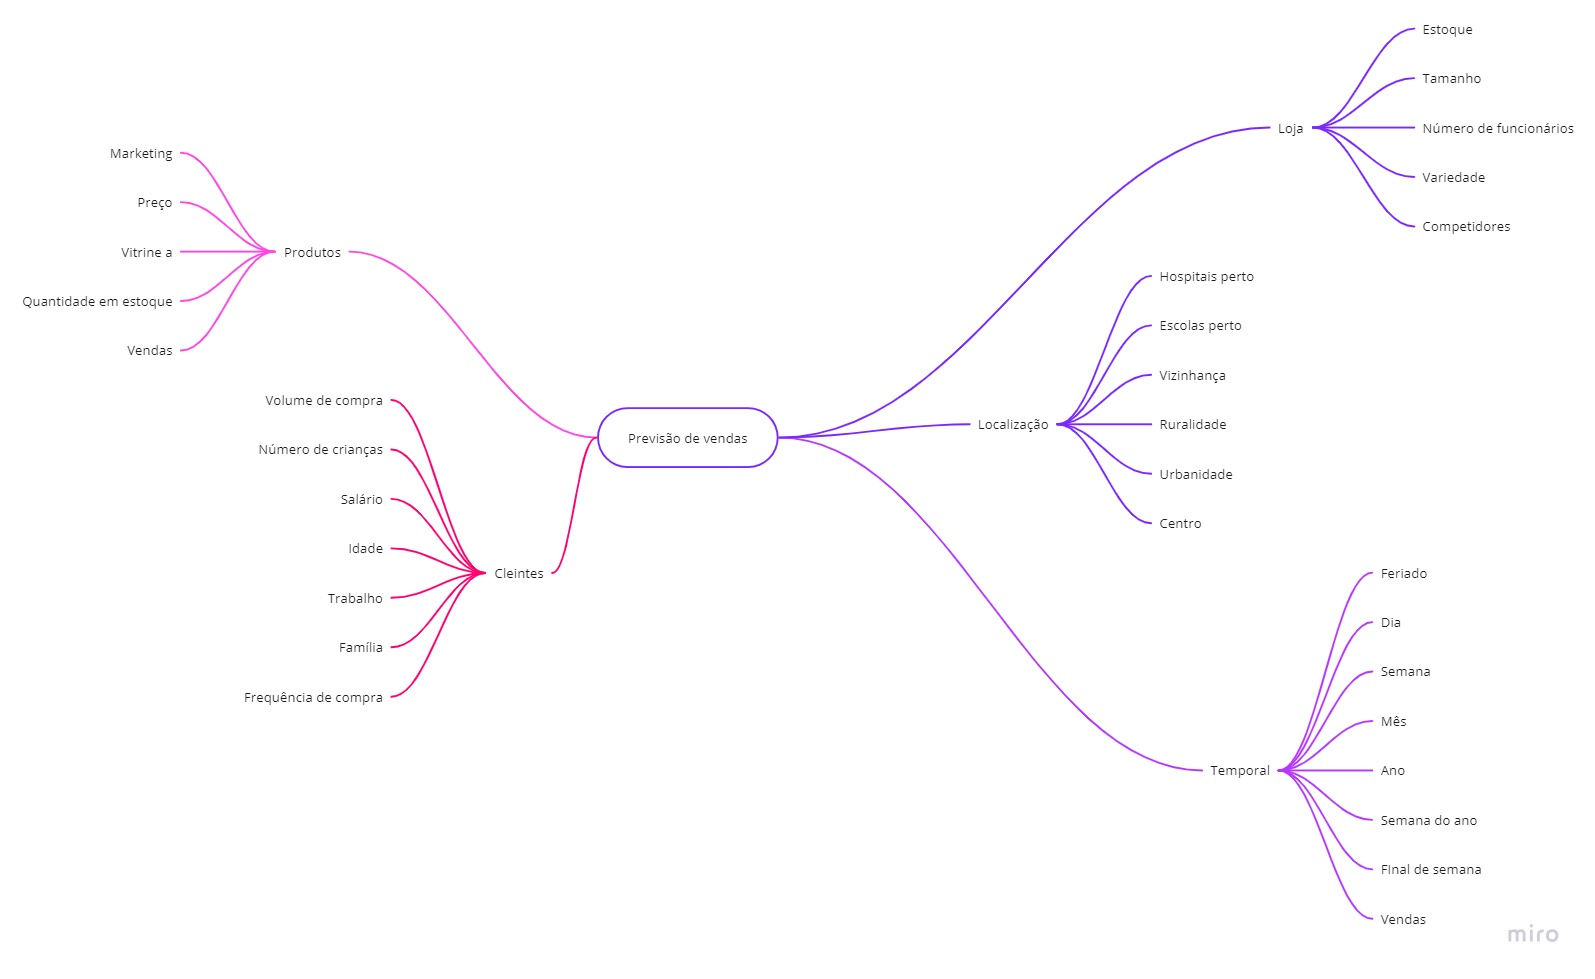

In [27]:
Image('../imgs/mindmap.jpg')

## Lista de hipóteses

| ID   | Hipótese                                                           | Relevância                       | Conclusão                      |
|------|------------------------------------------------------|----------------------------------|---------------------------------|
| H01. | Lojas com a maior variedade de produtos deveriam vender mais            | <font color="red">Alta</font>    | <font color="red">FALSA</font>  |
| H02. | Lojas com muitos competidores próximos deveriam vender menos               | <font color="red">Alta</font>    | <font color="red">FALSA</font>  |
| H03. | Lojas com competidores antigos deveriam vender mais | <font color="green">Baixa</font>   | <font color="red">FALSA</font>  |
| H04. | Lojas com promoções mais duradouras deveriam vender mais                | <font color="green">Baixa</font>   | <font color="red">FALSA</font>  |
| H05. | Lojas deveriam vender mais na segunda metade do ano        | <font color="green">Baixa</font>   | <font color="red">FALSA</font>  |
| H06. | Lojas com promoções consecutivas deveriam vender mais         | <font color="yellow">Média</font> | <font color="red">FALSA</font>  |
| H07. | Lojas abertas no natal deveriam vender mais                   | <font color="green">Baixa</font>   | <font color="red">FALSA</font>  |
| H08. | Lojas deveriam vender menos no final de semana                        | <font color="red">Alta</font>    | <font color="green">VERDADEIRA</font> |
| H09. | Lojas deveriam vender mais depois do dia 10 do mês                     | <font color="yellow">Média</font> | <font color="red">FALSA</font>  |
| H10. | Lojas deveriam vender mais com o passar dos anos                        | <font color="green">Baixa</font>   | <font color="red">FALSA</font>  |


## 3.1. Análise univariada

### 3.1.1. Variável resposta

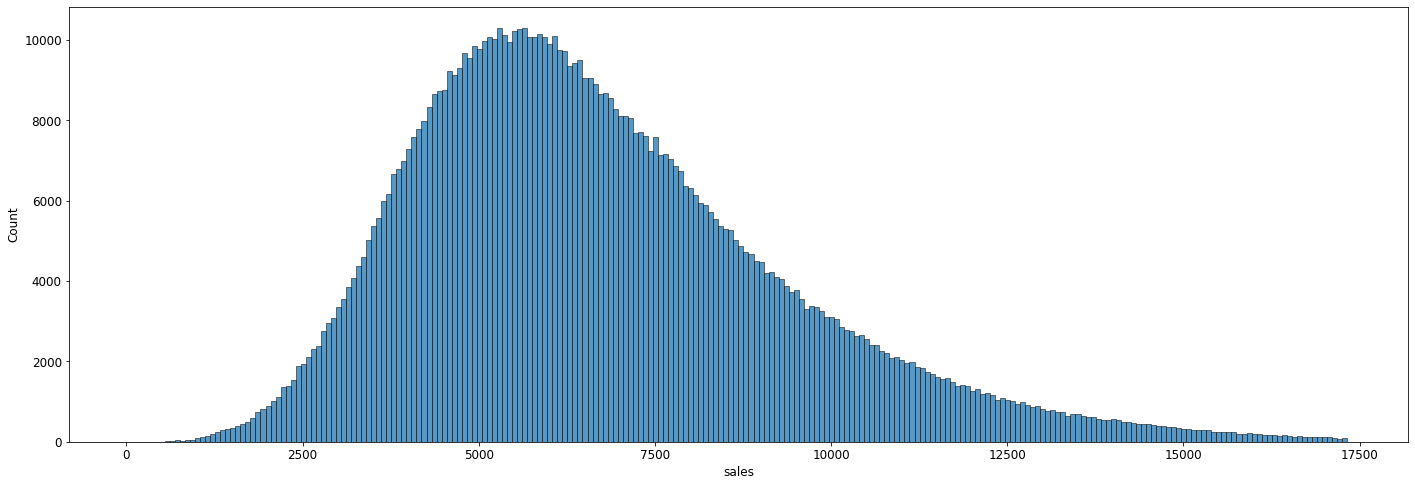

In [28]:
# definindo área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,8))

# plotagem
sns.histplot(df['sales'], ax=ax);

### 3.1.2. Variáveis numéricas

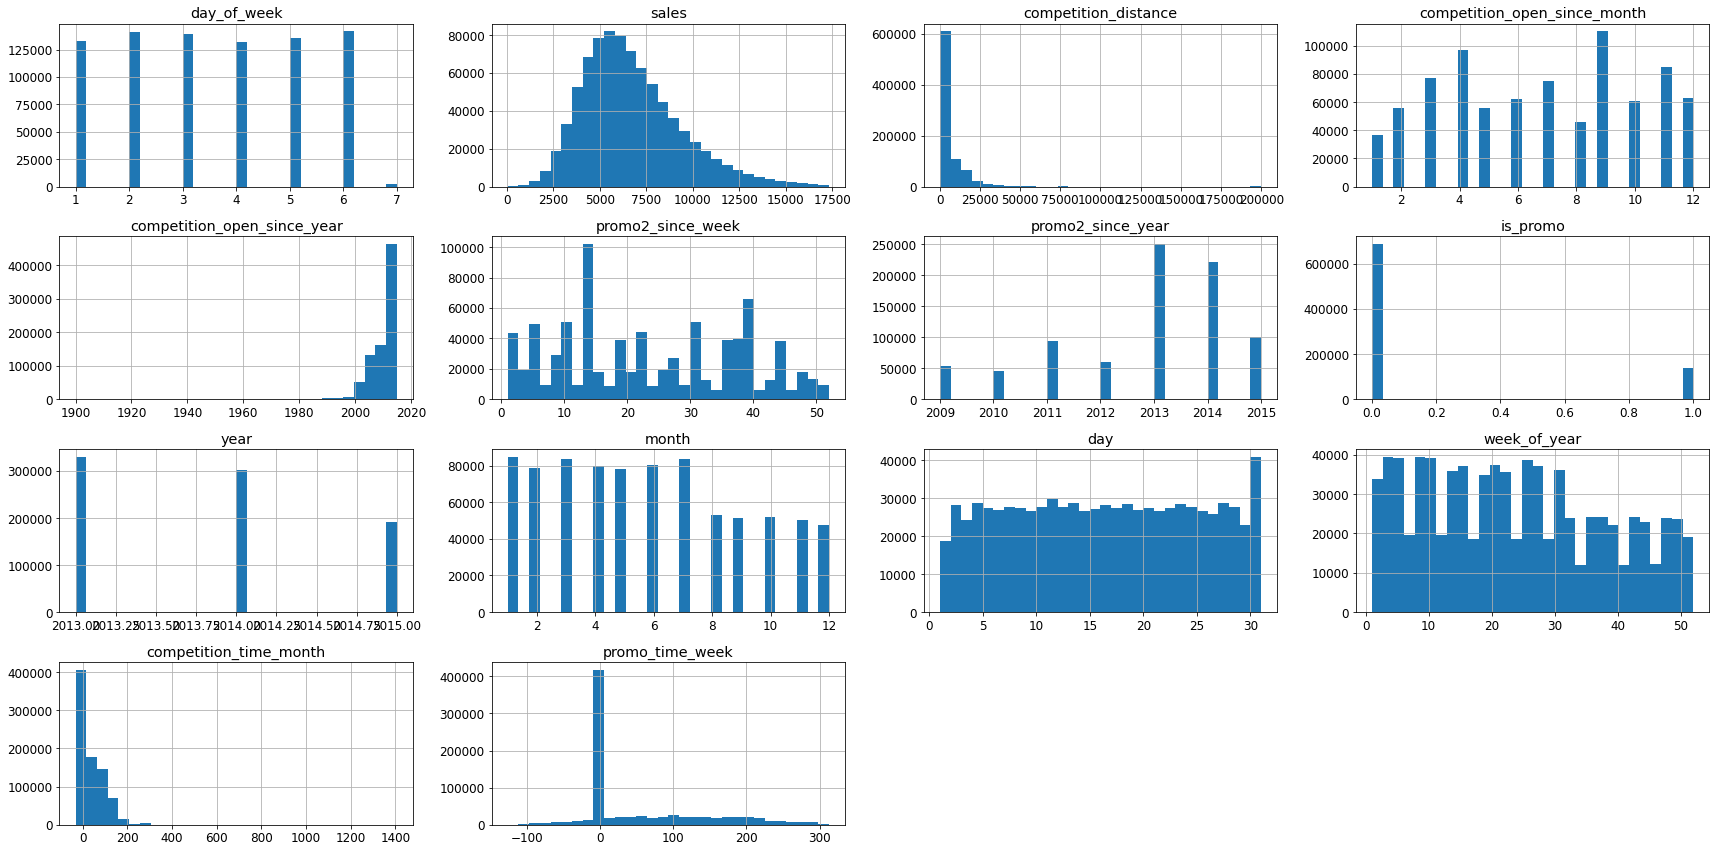

In [29]:
# plotagem
df.select_dtypes(include=['int64', 'float64']).hist(bins=30);
plt.tight_layout()

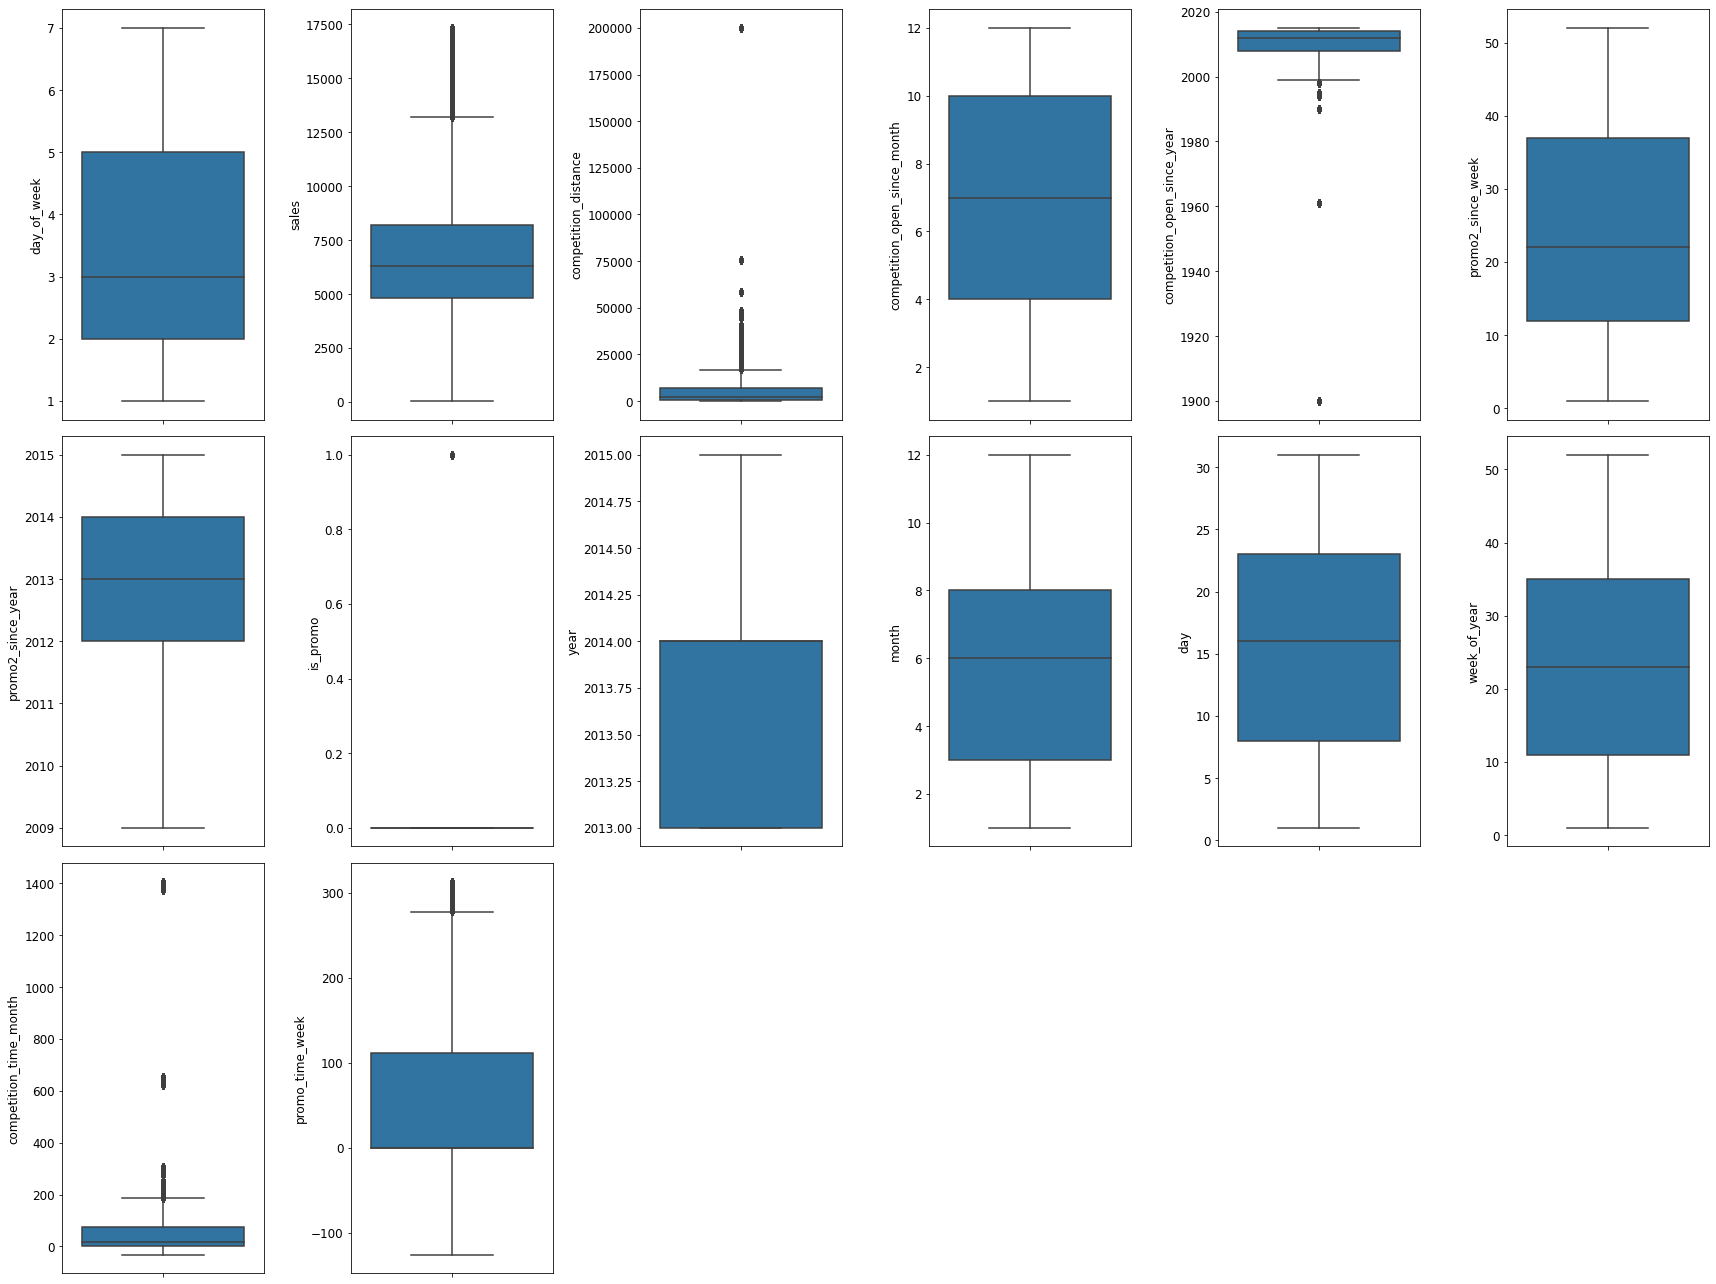

In [30]:
# definindo variável auxiliar e o tamanho da figura
auxiliar = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(24,18))

# plotagem
for i in range(0, len(auxiliar)):
    plt.subplot(3,6,i+1)
    sns.boxplot(y=df[auxiliar[i]], orient='v')
    plt.tight_layout()

### 3.1.3. Variáveis categóricas

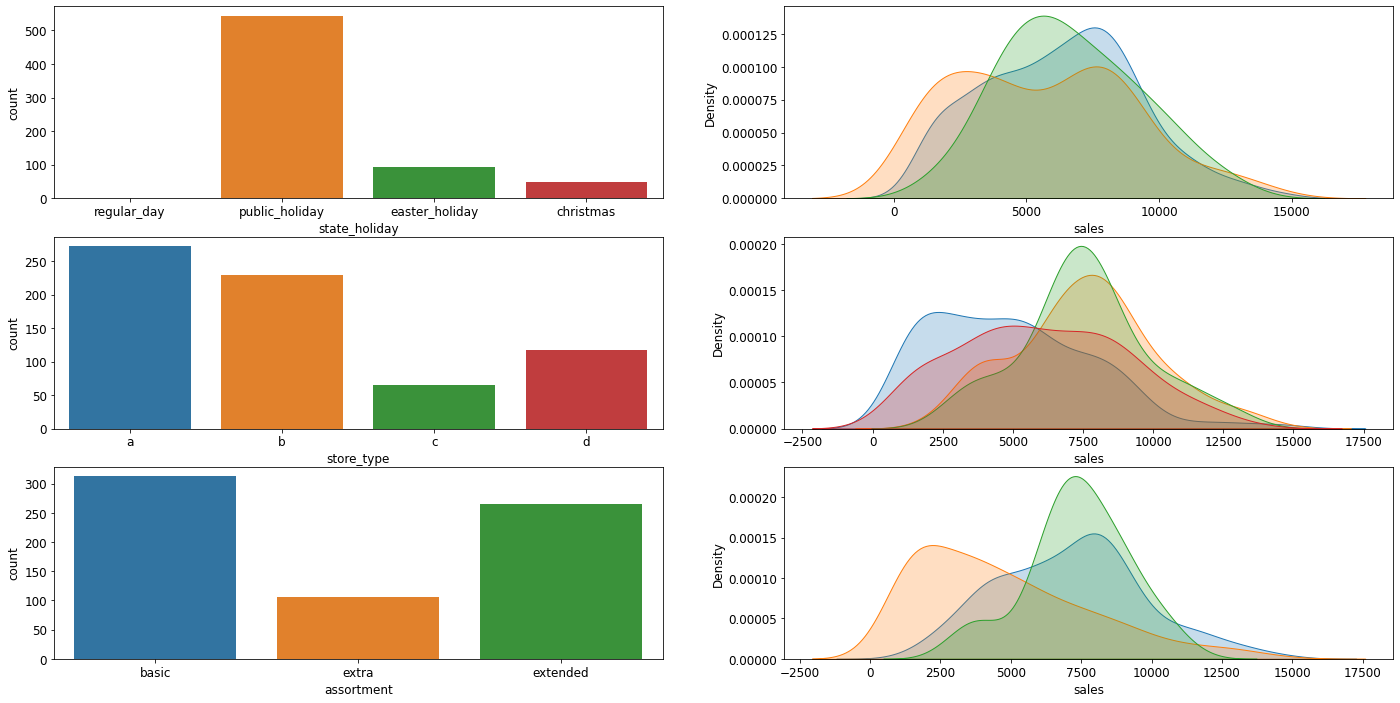

In [31]:
# definindo a variável auxiliar, área e formato dos gráficos
auxiliar = df[df['state_holiday'] != 'regular_day']
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,12))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = ax

# plotagem
## primeira linha
sns.countplot(x=auxiliar['state_holiday'], ax=ax1);
sns.kdeplot(x=auxiliar[auxiliar['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, ax=ax2);
sns.kdeplot(x=auxiliar[auxiliar['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, ax=ax2);
sns.kdeplot(x=auxiliar[auxiliar['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True, ax=ax2);

## segunda linha
sns.countplot(x=auxiliar['store_type'], ax=ax3);
sns.kdeplot(x=auxiliar[auxiliar['store_type'] == 'a']['sales'], label='a', shade=True, ax=ax4);
sns.kdeplot(x=auxiliar[auxiliar['store_type'] == 'b']['sales'], label='b', shade=True, ax=ax4);
sns.kdeplot(x=auxiliar[auxiliar['store_type'] == 'c']['sales'], label='c', shade=True, ax=ax4);
sns.kdeplot(x=auxiliar[auxiliar['store_type'] == 'd']['sales'], label='d', shade=True, ax=ax4);

# terceira linha
sns.countplot(x=auxiliar['assortment'], ax=ax5);
sns.kdeplot(x=auxiliar[auxiliar['assortment'] == 'basic']['sales'], label='basic', shade=True, ax=ax6);
sns.kdeplot(x=auxiliar[auxiliar['assortment'] == 'extended']['sales'], label='extended', shade=True, ax=ax6);
sns.kdeplot(x=auxiliar[auxiliar['assortment'] == 'extra']['sales'], label='extra', shade=True, ax=ax6);

## 3.2. Análise bivariada

### H01. Lojas com a maior variedade de produtos deveriam vender mais
<font color='red'>FALSO</font>

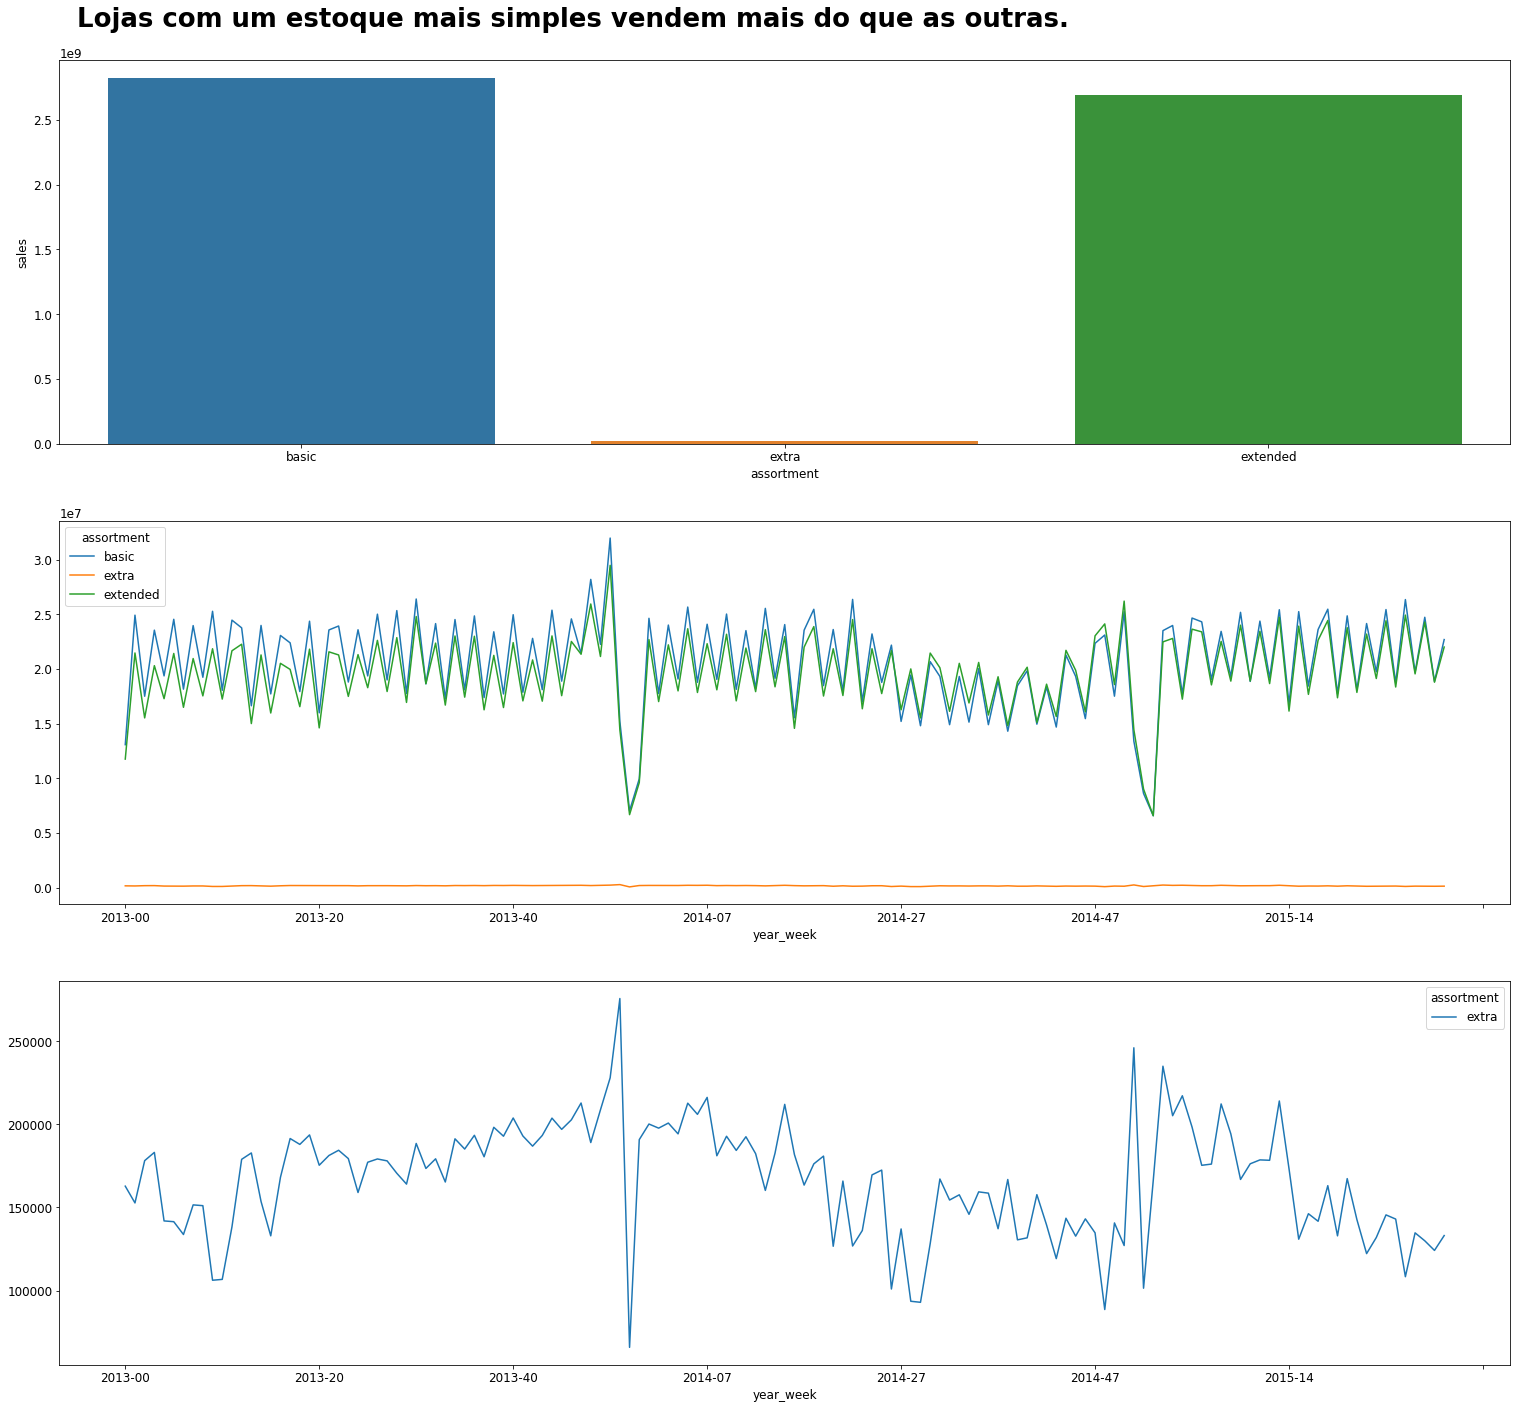

In [32]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=3, ncols=1, figsize=(26,24))
(ax1, ax2, ax3) = ax

# plotagem
## primeira linha
plt.text(x=-5., y=860_000., s='Lojas com um estoque mais simples vendem mais do que as outras.', fontweight='bold', fontsize=26)

auxiliar = df[['assortment', 'sales']].groupby(by='assortment').sum().reset_index()
sns.barplot(x=auxiliar['assortment'], y=auxiliar['sales'], ax=ax1);

## segunda linha
auxiliar2 = df[['year_week', 'assortment', 'sales']].groupby(by=['year_week', 'assortment']).sum().reset_index()
auxiliar2.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax2);

## terceira linha
auxiliar3 = auxiliar2[auxiliar2['assortment'] == 'extra']
auxiliar3.pivot(index='year_week', columns='assortment', values='sales').plot(ax=ax3);

### H02. Lojas com muitos competidores próximos deveriam vender menos
<font color='red'>FALSO</font>

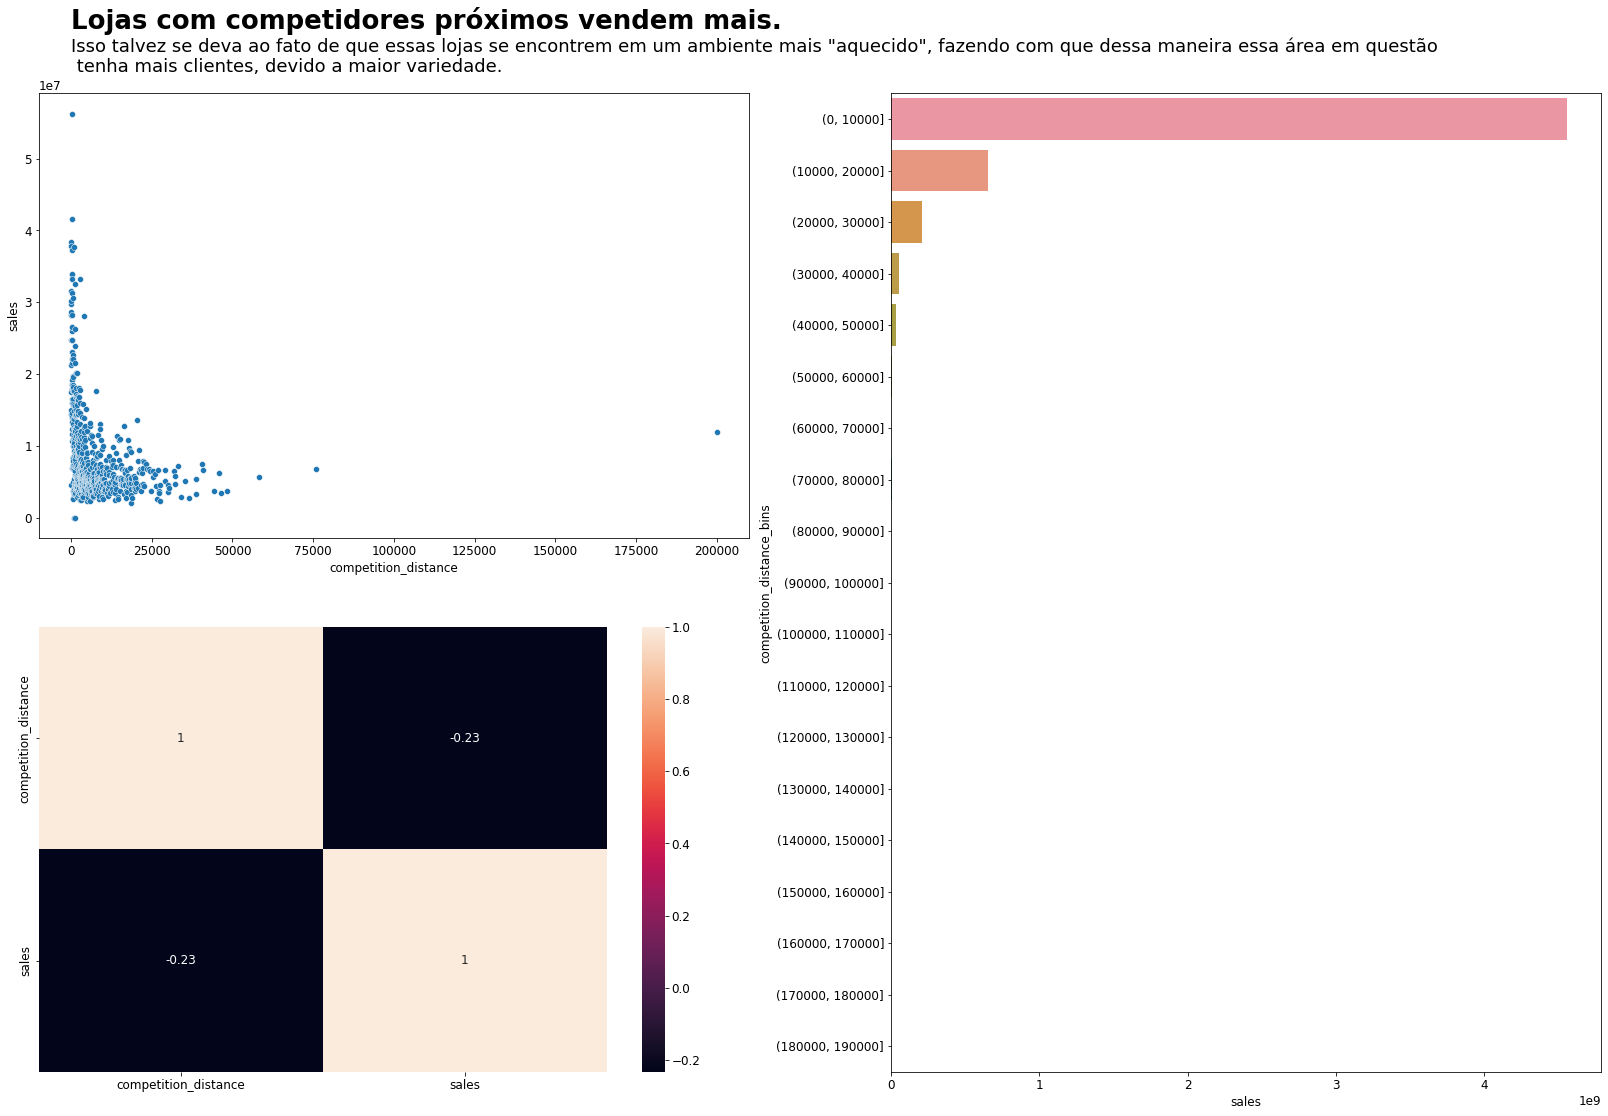

In [33]:
# definindo a variável auxiliar, área e formato dos gráficos
auxiliar = df[['competition_distance', 'sales']].groupby(by='competition_distance').sum().reset_index()
plt.figure(figsize=(28,18))

# plotagem
## primeiro gráfico
plt.subplot(2,2,1)
sns.scatterplot(x=auxiliar['competition_distance'], y=auxiliar['sales']);
plt.text(x=-5, y=68*1e6, s='Lojas com competidores próximos vendem mais.', fontweight='bold', fontsize=26)
plt.text(x=-5., y=62*1e6, s='Isso talvez se deva ao fato de que essas lojas se encontrem em um ambiente mais "aquecido", fazendo com que dessa maneira essa área em questão\n tenha mais clientes, devido a maior variedade.', fontsize=18)


## criação manual das bins
bins = list(np.arange(0, 200_000, 10_000))
auxiliar['competition_distance_bins'] = pd.cut(auxiliar['competition_distance'], bins=bins)
auxiliar2 = auxiliar[['competition_distance_bins', 'sales']].groupby(by='competition_distance_bins').sum().reset_index()

## segundo gráfico
plt.subplot(2,2,3)
sns.heatmap(auxiliar.corr(), annot=True);

## terceiro gráfico
plt.subplot(2,2,(2,4))
sns.barplot(x=auxiliar2['sales'], y=auxiliar2['competition_distance_bins']);

### H03. Lojas com competidores antigos deveriam vender mais
<font color='red'>FALSO</font>

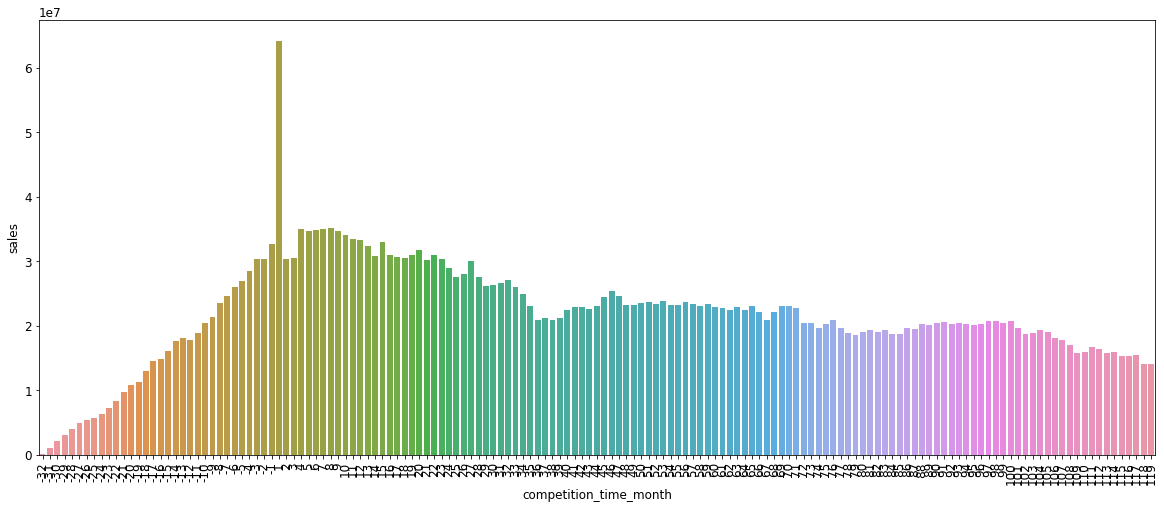

In [34]:
# definindo a variável auxiliar, área e formato dos gráficos
auxiliar = df[['competition_time_month', 'sales']].groupby(by='competition_time_month').sum().reset_index()
auxiliar = auxiliar[(auxiliar['competition_time_month'] < 120) & (auxiliar['competition_time_month'] != 0)]
plt.figure(figsize=(20,8))

# plotagem
sns.barplot(x=auxiliar['competition_time_month'], y=auxiliar['sales']);
plt.xticks(rotation=90);

### H04. Lojas com promoções mais duradouras deveriam vender mais
<font color='red'>FALSO</font>

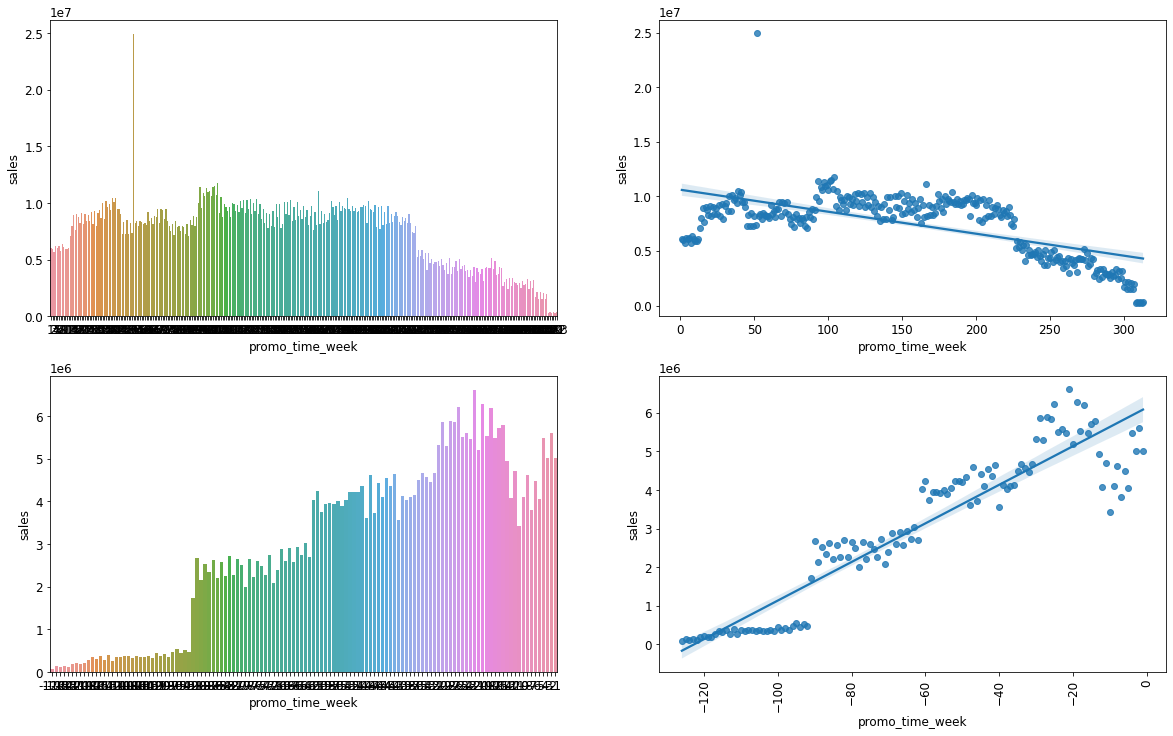

In [35]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
(ax1, ax2), (ax3, ax4) = ax

# plotagem
## extended promo
auxiliar = df[['promo_time_week', 'sales']].groupby(by='promo_time_week').sum().reset_index()
auxiliar = auxiliar[auxiliar['promo_time_week'] > 0]
sns.barplot(x=auxiliar['promo_time_week'], y=auxiliar['sales'], ax=ax1);
plt.xticks(rotation=90);
sns.regplot(x=auxiliar['promo_time_week'], y=auxiliar['sales'], ax=ax2);

## regular promo
auxiliar2 = df[['promo_time_week', 'sales']].groupby(by='promo_time_week').sum().reset_index()
auxiliar2 = auxiliar2[auxiliar2['promo_time_week'] < 0]
sns.barplot(x=auxiliar2['promo_time_week'], y=auxiliar2['sales'], ax=ax3);
plt.xticks(rotation=90);
sns.regplot(x=auxiliar2['promo_time_week'], y=auxiliar2['sales'], ax=ax4);

### H05. Lojas deveriam vender mais na segunda metade do ano
<font color='red'>FALSO</font>

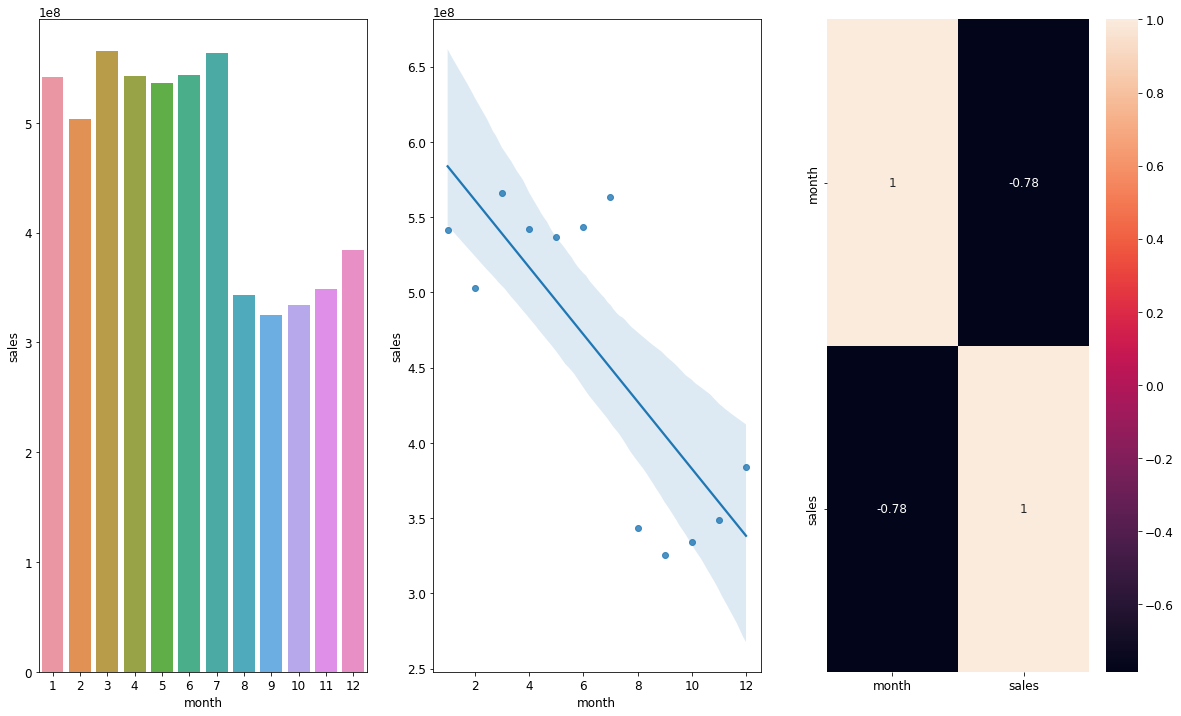

In [36]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,12))
(ax1, ax2, ax3) = ax

# plotagem
## primeira coluna
aux1 = df[['month', 'sales']].groupby(by='month').sum().reset_index()
sns.barplot(x=aux1['month'], y=aux1['sales'], ax=ax1);

## segunda coluna
sns.regplot(x=aux1['month'], y=aux1['sales'], ax=ax2);

## terceira coluna
sns.heatmap(aux1.corr(), annot=True, ax=ax3);

### H06. Lojas com promoções consecutivas deveriam vender mais
<font color='red'>FALSO</font>

In [37]:
# tabela com todas as combinações de promoções 1 e 2
df_promos_consec = df[['promo', 'promo2', 'sales']].groupby(by=['promo', 'promo2']).sum().reset_index()

# formatando a coluna 'sales' para uma melhor visualização
df_promos_consec['sales'] = df_promos_consec['sales'].map('{:,}'.format)

# exibindo a tabela final
df_promos_consec.sort_values(by='sales', ascending=False)

,promo,promo2,sales
2,1,0,"1,473,683,452"
3,1,1,"1,425,524,385"
0,0,0,"1,365,219,311"
1,0,1,"1,268,076,234"


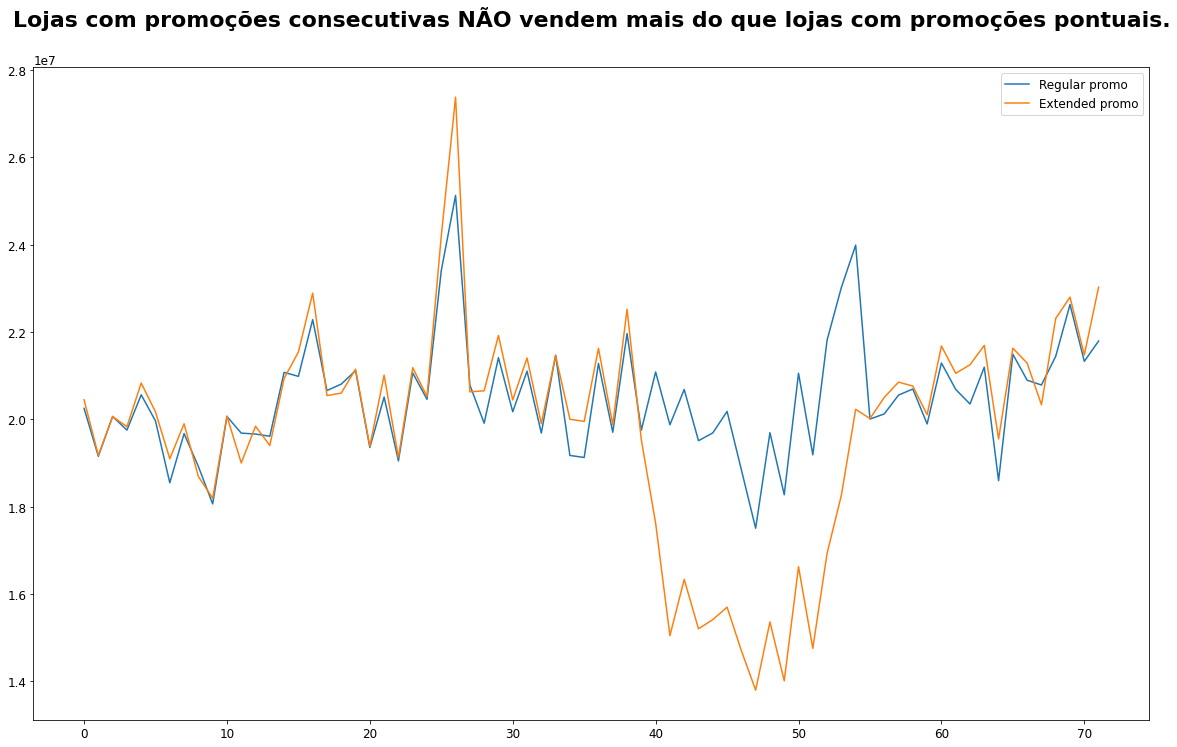

In [38]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
plt.text(x=-5, y=2.9e7, s='Lojas com promoções consecutivas NÃO vendem mais do que lojas com promoções pontuais.', fontweight='bold', fontsize=22)

# plotagem
df[(df['promo'] == 1) & (df['promo2'] == 0)][['year_week', 'sales']].groupby(by='year_week').sum().reset_index().plot(ax=ax);
df[(df['promo'] == 1) & (df['promo2'] == 1)][['year_week', 'sales']].groupby(by='year_week').sum().reset_index().plot(ax=ax);
ax.legend(labels=['Regular promo', 'Extended promo']);

### H07. Lojas abertas no natal deveriam vender mais
<font color='red'>FALSO</font>

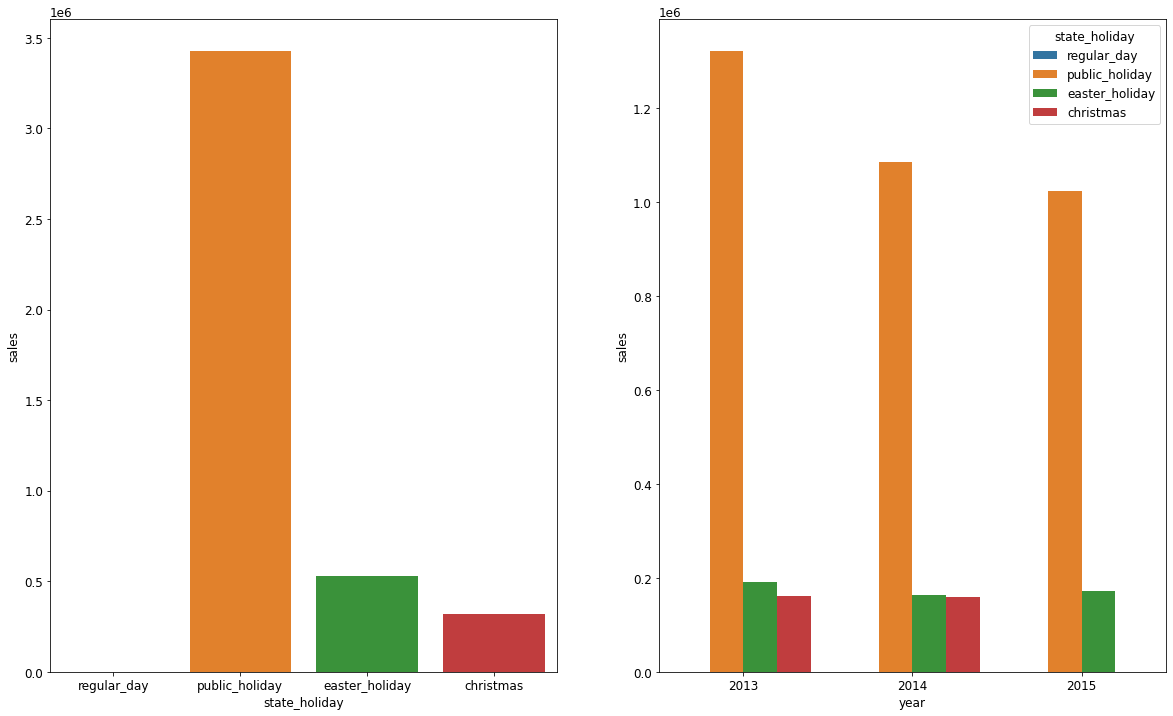

In [39]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
(ax1, ax2) = ax

# plotagem
## primeira coluna
auxiliar = df[df['state_holiday'] != 'regular_day']
auxiliar = auxiliar[['state_holiday', 'sales']].groupby(by='state_holiday').sum().reset_index()
sns.barplot(x=auxiliar['state_holiday'], y=auxiliar['sales'], ax=ax1);

## segunda coluna
auxiliar2 = df[df['state_holiday'] != 'regular_day']
auxiliar2 = auxiliar2[['year', 'state_holiday', 'sales']].groupby(by=['year', 'state_holiday']).sum().reset_index()
sns.barplot(x=auxiliar2['year'], y=auxiliar2['sales'], hue=auxiliar2['state_holiday'], ax=ax2);

### H08. Lojas deveriam vender menos no final de semana
<font color='green'>VERDADEIRO</font>

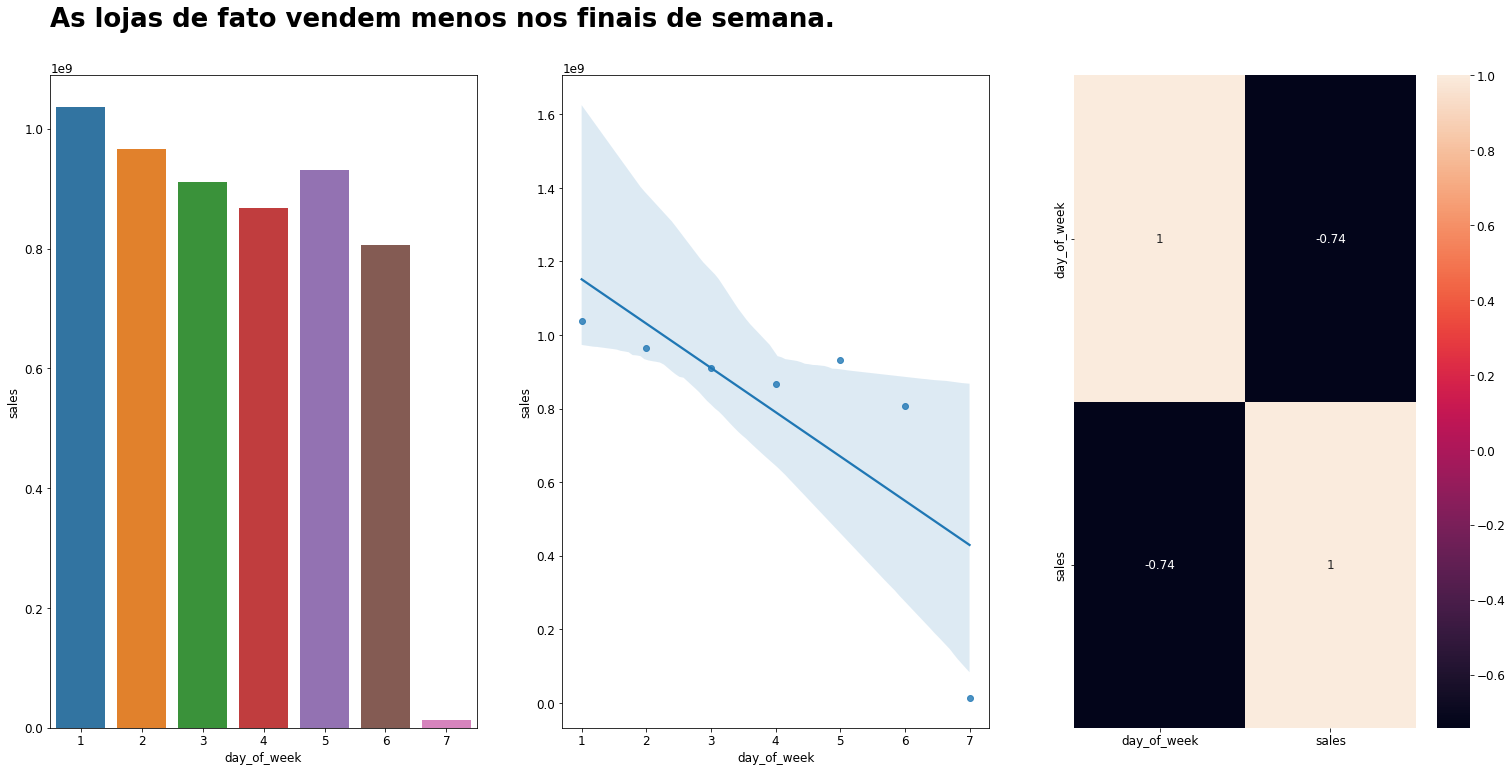

In [40]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,12))
(ax1, ax2, ax3) = ax

# plotagem
## primeira coluna
auxiliar = df[['day_of_week', 'sales']].groupby(by='day_of_week').sum().reset_index()
sns.barplot(x=auxiliar['day_of_week'], y=auxiliar['sales'], ax=ax1);
plt.text(x=-6, y=-0.15, s='As lojas de fato vendem menos nos finais de semana.', fontweight='bold', fontsize=26)

## segunda coluna
sns.regplot(x=auxiliar['day_of_week'], y=auxiliar['sales'], ax=ax2);

## terceira coluna
sns.heatmap(auxiliar.corr(), annot=True, ax=ax3);

### H09. Lojas deveriam vender mais depois do dia 10 do mês
<font color='red'>FALSO</font>

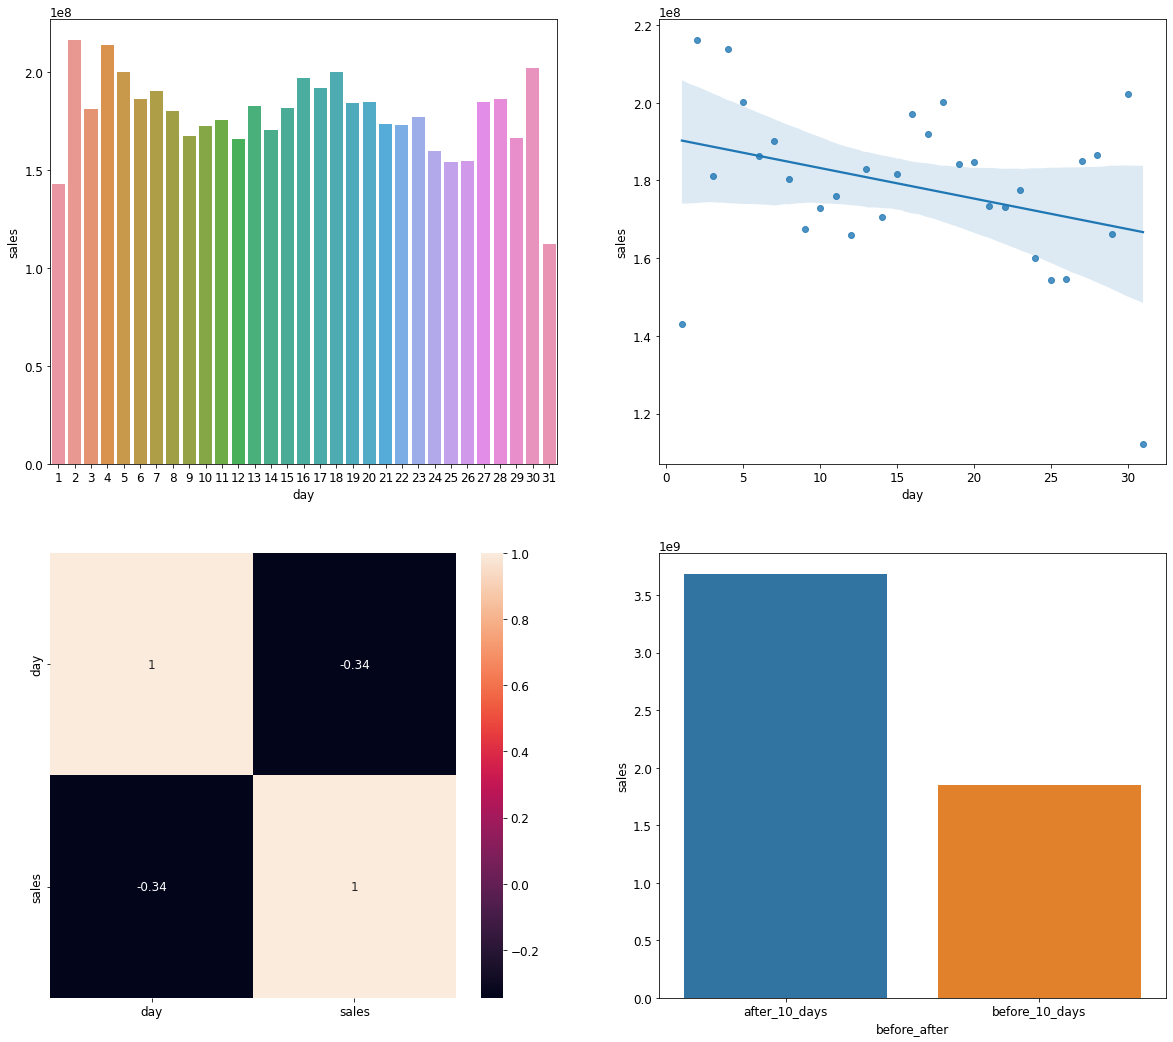

In [41]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,18))
(ax1, ax2), (ax3, ax4) = ax

# plotagem
## primeira linha
auxiliar = df[['day', 'sales']].groupby(by='day').sum().reset_index()
sns.barplot(x=auxiliar['day'], y=auxiliar['sales'], ax=ax1);

sns.regplot(x=auxiliar['day'], y=auxiliar['sales'], ax=ax2);

## segunda linha
sns.heatmap(auxiliar.corr(), annot=True, ax=ax3);
auxiliar['before_after'] = auxiliar['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

auxiliar = auxiliar[['before_after', 'sales']].groupby(by='before_after').sum().reset_index()
sns.barplot(x=auxiliar['before_after'], y=auxiliar['sales'], ax=ax4);

### H10. Lojas deveriam vender mais com o passar dos anos
**Observação:** o ano de 2015 ainda não está com todas as entradas do ano.
<br>
<font color='red'>FALSO</font>

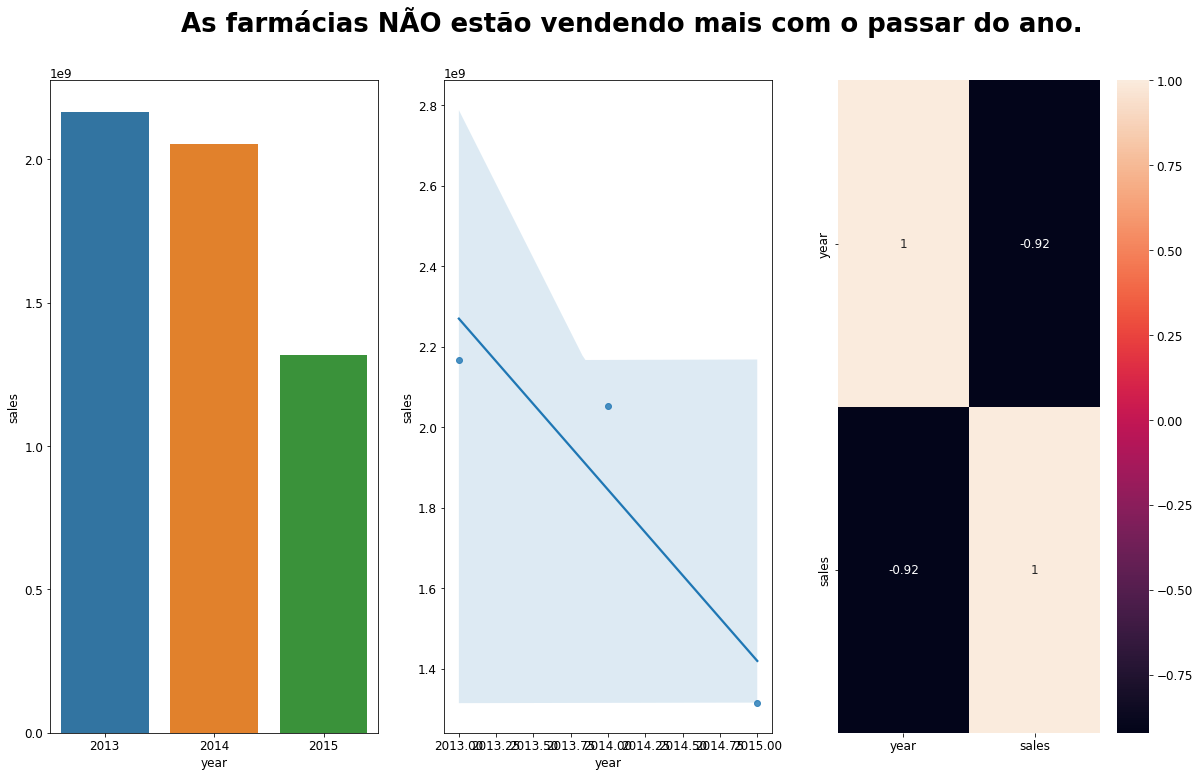

In [42]:
# definindo a área e formato dos gráficos
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,12))
(ax1, ax2, ax3) = ax
plt.text(x=-5, y=-0.15, s='As farmácias NÃO estão vendendo mais com o passar do ano.', fontweight='bold', fontsize=26)

# plotagem
## primeira coluna
auxiliar = df[['year', 'sales']].groupby(by='year').sum().reset_index()
sns.barplot(x=auxiliar['year'], y=auxiliar['sales'], ax=ax1);

## segunda coluna
sns.regplot(x=auxiliar['year'], y=auxiliar['sales'], ax=ax2);

## terceira coluna
sns.heatmap(auxiliar.corr(), annot=True, ax=ax3);

## 3.3. Análise multivariada

### 3.3.1. Variáveis numéricas

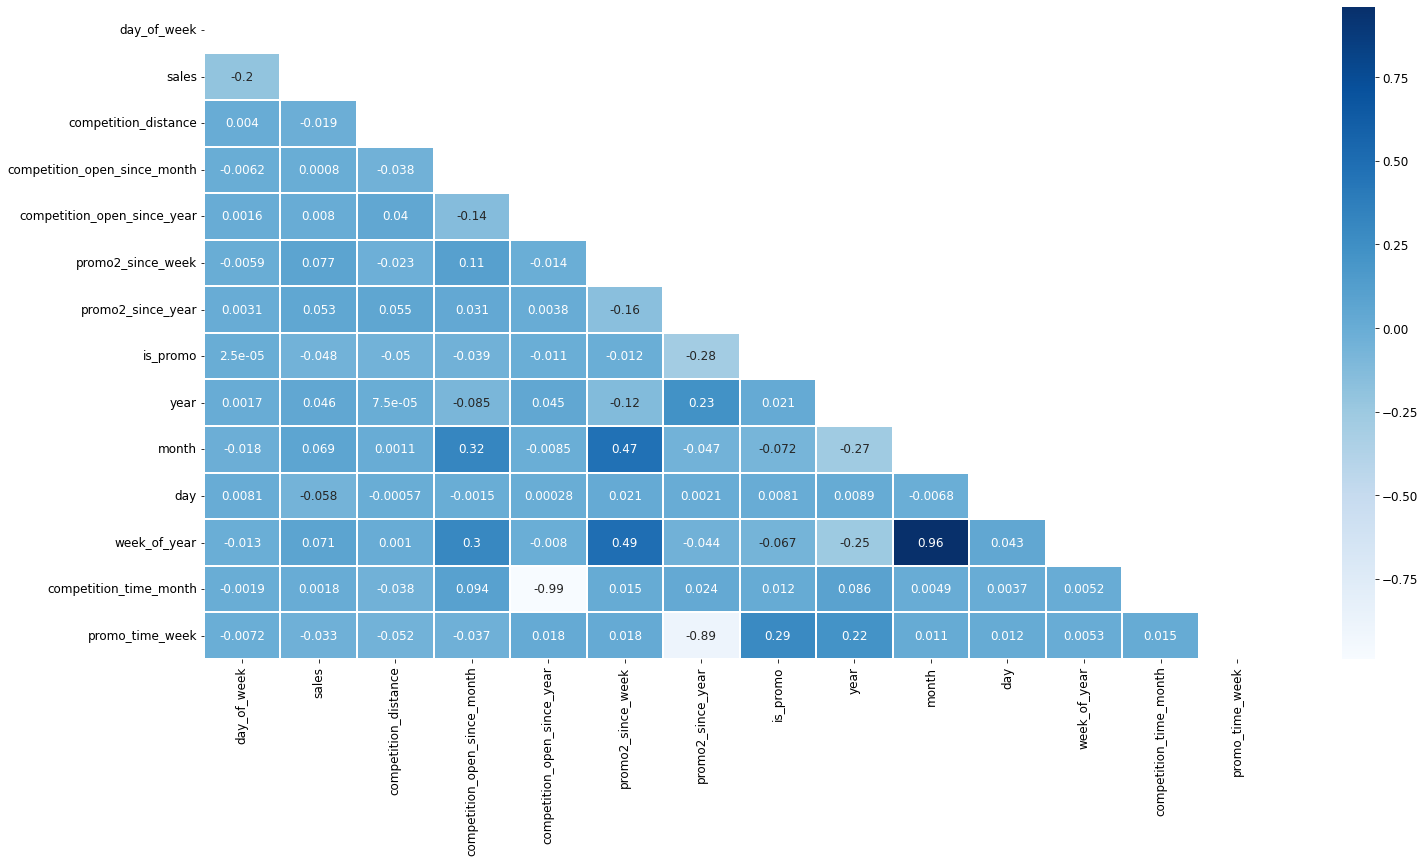

In [43]:
# computando a matriz de correlação
corr_numerica = df.select_dtypes(exclude=['category', 'object']).corr()

# criando a máscara do gráfico
mascara = np.triu(np.ones_like(corr_numerica, dtype=bool))

# plotagem
sns.heatmap(corr_numerica, mask=mascara, cmap='Blues', annot=True, linewidths=2);

### 3.3.2. Variáveis categóricas

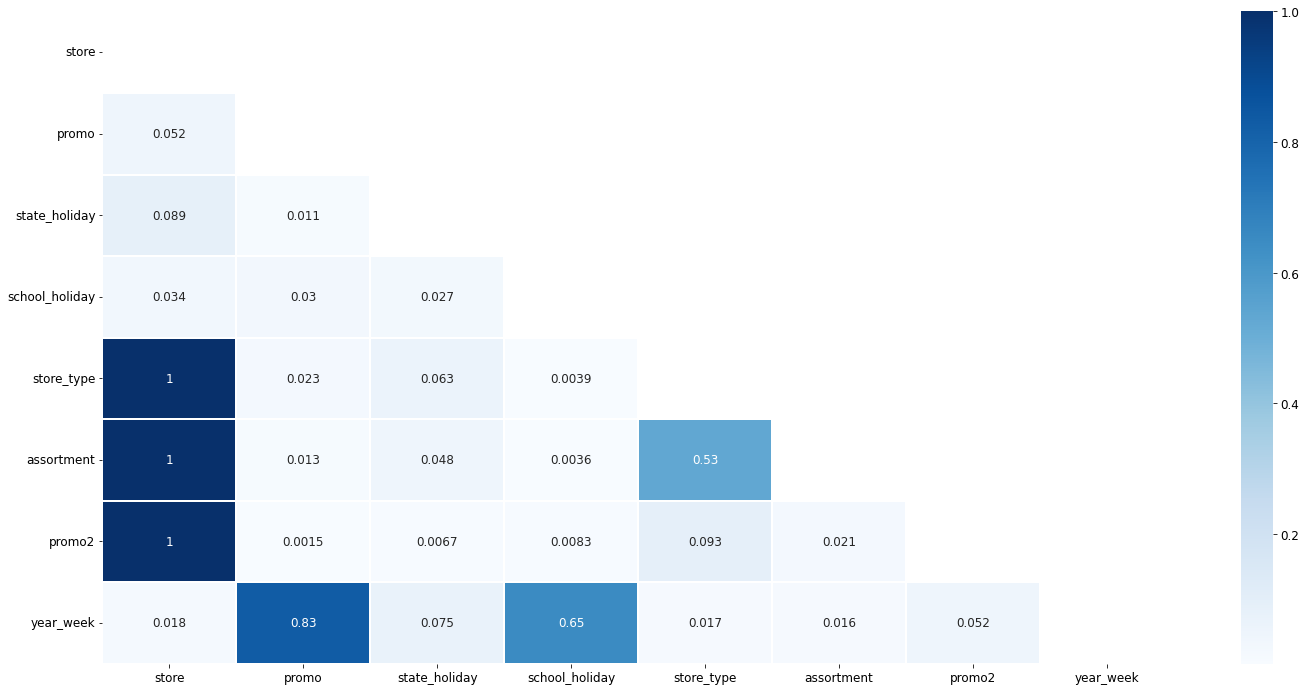

In [44]:
# only categorical variables
variaveis_cat = df.select_dtypes(['object', 'category'])

dic_corr_cat = {}
df_corr_cat = pd.DataFrame()
for x in variaveis_cat.columns:
    dic_corr_cat[x] = []
    
    for y in variaveis_cat.columns:
        # calculando cramer's v
        dic_corr_cat[x].append(mtb.cramers_v(variaveis_cat[x], variaveis_cat[y]))

    # dataframe final
    df_corr_cat = pd.DataFrame(dic_corr_cat).set_index(variaveis_cat.columns)

# criando a máscara do gráfico
mask = np.triu(np.ones_like(df_corr_cat, dtype=bool))

# plotagem
sns.heatmap(df_corr_cat, mask=mask, cmap='Blues', annot=True, linewidths=2);

# 4. Pré-processamento de dados

## 4.1. Separação dos dados

In [45]:
# conjunto de treino
x_train = df[df['date'] < '2015-06-19']
y_train = x_train['sales']

# conjunto de validação
x_val = df[df['date'] >= '2015-06-19']
y_val = x_val['sales']

In [46]:
# checando
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print()
print('Treino data mínima: {}'.format(x_train['date'].min()))
print('Treino data máxima {}'.format(x_train['date'].max()))
print()
print('Validação data mínima: {}'.format(x_val['date'].min()))
print('Validação data máxima: {}'.format(x_val['date'].max()))

(783653, 25) (783653,) (40453, 25) (40453,)

Treino data mínima: 2013-01-01 00:00:00
Treino data máxima 2015-06-18 00:00:00

Validação data mínima: 2015-06-19 00:00:00
Validação data máxima: 2015-07-31 00:00:00


## 4.2. Reescala

### 4.2.1. MinMax Scaler

In [47]:
# instanciando o objeto
mms = pp.MinMaxScaler()

# aplicando a reescala
for col in ['year', 'promo_time_week']:
    x_train.loc[:, col] = mms.fit_transform(x_train.loc[:, [col]])
    joblib.dump(mms, f'../parameters/mms_{col}.pkl')
    x_val.loc[:, col] = mms.transform(x_val.loc[:, [col]])

C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\556543173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train.loc[:, col] = mms.fit_transform(x_train.loc[:, [col]])
C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\556543173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val.loc[:, col] = mms.transform(x_val.loc[:, [col]])
C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\556543173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

### 4.2.2. Robust Scaler

In [48]:
# instanciando o objeto
rs = pp.RobustScaler()

# aplicando a reescala
for col in ['competition_distance', 'competition_time_month']:
    x_train.loc[:, col] = rs.fit_transform(x_train.loc[:, [col]])
    joblib.dump(rs, f'../parameters/rs_{col}.pkl')
    x_val.loc[:, col] = rs.transform(x_val.loc[:, [col]])

C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\655873138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train.loc[:, col] = rs.fit_transform(x_train.loc[:, [col]])
C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\655873138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val.loc[:, col] = rs.transform(x_val.loc[:, [col]])
C:\Users\gbrce\AppData\Local\Temp\ipykernel_11032\655873138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

## 4.3. Encoding

### 4.3.1 One-Hot (Dummy) Encoding

In [49]:
# aplicando a técnica de encoding
x_train = pd.get_dummies(x_train, columns=['state_holiday', 'store_type'])
x_val = pd.get_dummies(x_val, columns=['state_holiday', 'store_type'])

### 4.3.2. Ordinal Encoding

In [50]:
# aplicando a técnica de encoding
x_train['assortment'] = x_train['assortment'].map({'basic': 1, 'extra': 2, 'extended': 3})
x_val['assortment'] = x_val['assortment'].map({'basic': 1, 'extra': 2, 'extended': 3})

## 4.4. Transformação

### 4.4.1. Nature transformation

In [51]:
# aplicando a técnica de transformação para que que tenhamos uma correspondência cíclica nas features
## month
x_train['month_sin'] = x_train['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
x_train['month_cos'] = x_train['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

x_val['month_sin'] = x_val['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
x_val['month_cos'] = x_val['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

## day
x_train['day_sin'] = x_train['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
x_train['day_cos'] = x_train['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

x_val['day_sin'] = x_val['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
x_val['day_cos'] = x_val['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

## week of year
x_train['week_of_year_sin'] = x_train['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
x_train['week_of_year_cos'] = x_train['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

x_val['week_of_year_sin'] = x_val['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
x_val['week_of_year_cos'] = x_val['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

## day of week
x_train['day_of_week_sin'] = x_train['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
x_train['day_of_week_cos'] = x_train['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

x_val['day_of_week_sin'] = x_val['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
x_val['day_of_week_cos'] = x_val['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# 5. Seleção de features

In [52]:
# dropando colunas que serviram como fonte de derivação
colunas_dropar = ['day', 'month', 'day_of_week', 'year_week', 'week_of_year', 'competition_since', 'promo_since']

# excluindo
x_train.drop(colunas_dropar, axis=1, inplace=True)
x_val.drop(colunas_dropar, axis=1, inplace=True)    

## 5.1. RFE (Recursive Feature Elimination) como seletor

In [ ]:
# instanciando e treinando
seletor_rfe = RFECV(XGBRegressor(), cv=5, min_features_to_select=6, step=1, verbose=1)\
              .fit(x_train.drop(['date', 'sales'], axis=1), y_train)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 featu

In [ ]:
# colunas selecionadas
selecionadas_rfe = [x for x, y in zip(x_train.drop(['date', 'sales'], axis=1).columns, seletor_rfe.support_) if y == True]
selecionadas_rfe

['store',
 'promo',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'year',
 'competition_time_month',
 'promo_time_week',
 'store_type_a',
 'store_type_b',
 'store_type_c',
 'store_type_d',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [99]:
# colunas NÃO selecionadas
nao_selecionadas_rfe = list(np.setdiff1d(x_train.columns, selecionadas_rfe))
nao_selecionadas_rfe

['date',
 'is_promo',
 'sales',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day']

## 5.2. Importância de features como seletor

In [101]:
# instanciando e treinando
seletor_rf = RandomForestRegressor().fit(x_train.drop(['date', 'sales'], axis=1), y_train)

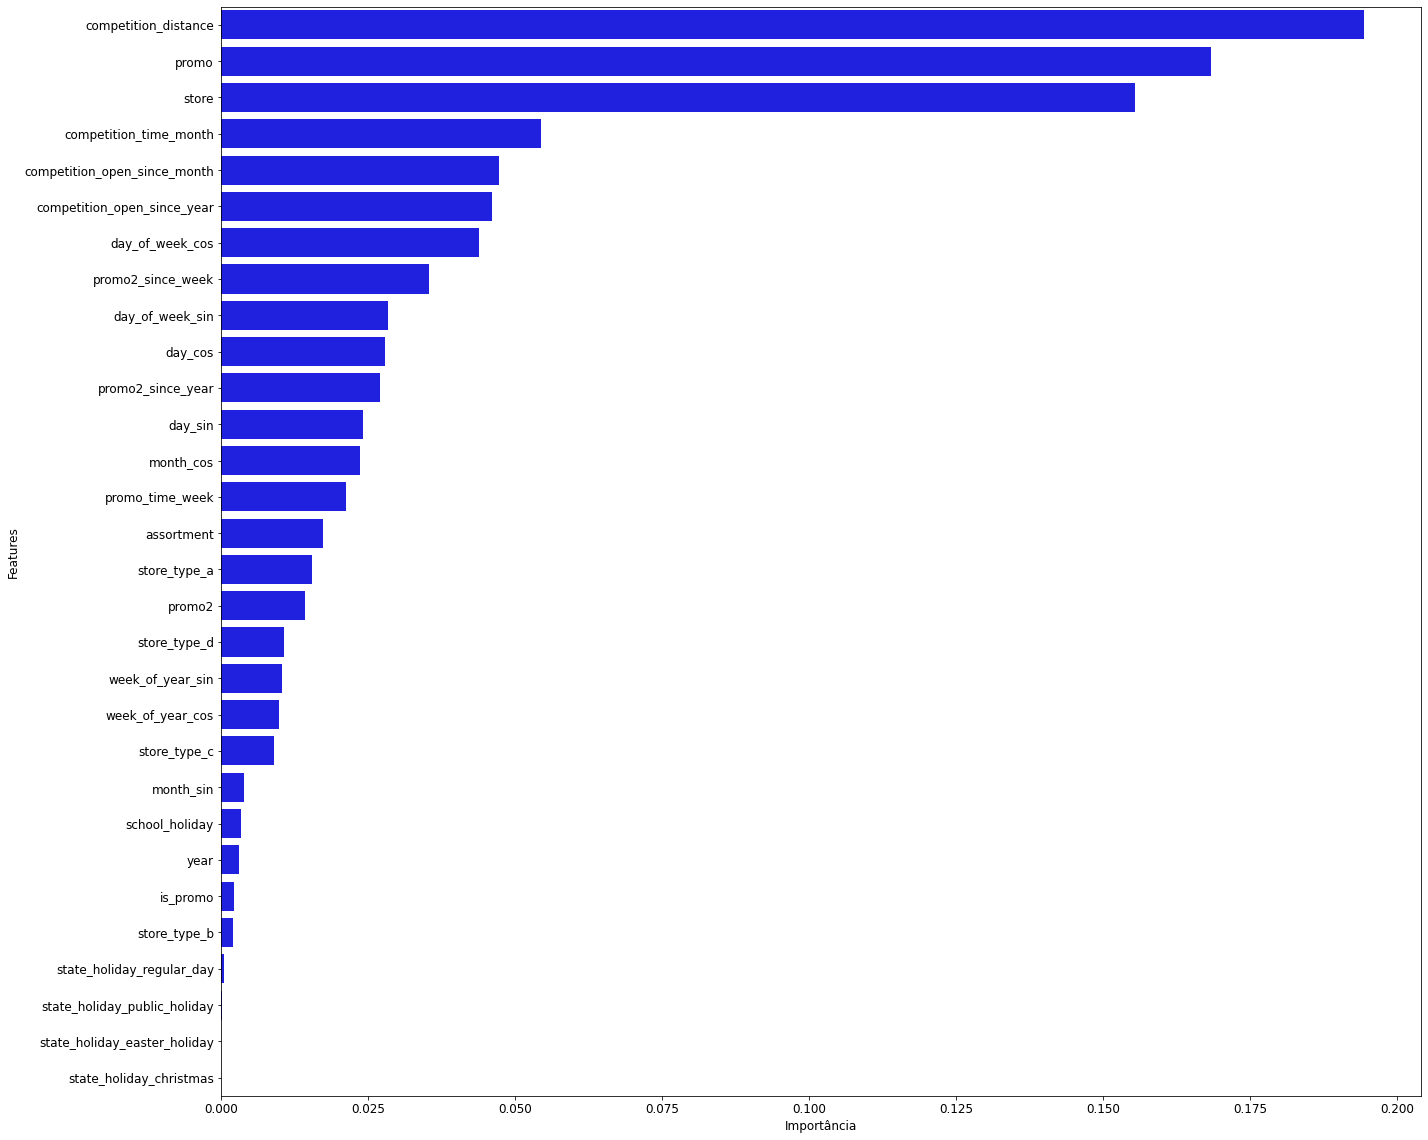

In [104]:
# criando o dataframe
df_seletor_rf = pd.DataFrame({'Features': x_train.drop(['date', 'sales'], axis=1).columns,
                              'Importância': seletor_rf.feature_importances_})\
                              .sort_values(by='Importância', ascending=False)\
                              .reset_index(drop=True)

# definindo a área e formato do gráfico
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,16))

# plotagem
sns.barplot(x='Importância', y='Features', data=df_seletor_rf, color='blue', ax=ax);
plt.tight_layout()

## 5.3. Seleção final das colunas

In [53]:
# selecionando a dedo as colunas finais escolhidas pelo modelo de rf e rfe
colunas_finais = ['assortment', 'competition_distance', 'promo', 'store', 'competition_time_month', 'competition_open_since_month',
                  'competition_open_since_year', 'day_of_week_sin', 'day_of_week_cos', 'promo2_since_week', 'promo2_since_year', 'date', 'sales']

# conjuntos finais
## separando conjunto para validação cruzada de linhas temporais e para conversão de negócios
X_train = x_train.loc[:, colunas_finais]
X_val = x_val.loc[:, colunas_finais]

## conjuntos de treino e validação
x_train = x_train.loc[:, colunas_finais[:-2]]
x_val = x_val.loc[:, colunas_finais[:-2]]

# 6. Machine learning modeling

## 6.1. Baseline

In [54]:
# instanciando e treinando o modelo
modelo_dummy = DummyRegressor().fit(x_train, y_train)

# predizendo
yhat_dummy = modelo_dummy.predict(x_val)

# metrificando
m1 = model_performance(model_name='Baseline', y_true=y_val, y_pred=yhat_dummy)
m1

,Model name,MAE,MAPE,RMSE
0,Baseline,2035.568,0.359,2612.378


## 6.2. Regressão linear múltipla

In [55]:
# instanciando e treinando o modelo
modelo_mlr = LinearRegression().fit(x_train, y_train)

# predizendo
yhat_mlr = modelo_mlr.predict(x_val)

# metrificando
m2 = model_performance(model_name='Regressão linear múltipla', y_true=y_val, y_pred=yhat_mlr)
m2

,Model name,MAE,MAPE,RMSE
0,Regressão linear múltipla,1767.191,0.318,2253.373


### 6.2.1. Regressão linear múltipla com validação cruzada

In [56]:
# treinando, predizendo e metrificando através da técnica de validação cruzada
m2_cv = cross_validation(kfold=10, estimator=LinearRegression(), x=X_train, verbose=False)
m2_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,1838.73 +/- 137.62,0.32 +/- 0.02,2354.8 +/- 208.36


## 6.3. Lasso

In [57]:
# instanciando e treinando o modelo
modelo_lasso = Lasso().fit(x_train, y_train)

# predizendo
yhat_lasso = modelo_lasso.predict(x_val)

# metrificando
m3 = model_performance(model_name='Lasso', y_true=y_val, y_pred=yhat_lasso)
m3

,Model name,MAE,MAPE,RMSE
0,Lasso,1763.719,0.316,2251.794


### 6.3. Lasso com validação cruzada

In [58]:
# treinando, predizendo e metrificando através da técnica de validação cruzada
m3_cv = cross_validation(kfold=10, estimator=Lasso(), x=X_train, verbose=False)
m3_cv

c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.127e+09, tolerance: 2.936e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e+09, tolerance: 3.205e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1835.17 +/- 140.95,0.31 +/- 0.02,2354.01 +/- 212.32


## 6.4. Random forest
Pelo fato do modelo em questão ser demasiadamente mais custoso, resolvi fazer algumas modificações em seus parâmetros e hiperparâmetros.

In [59]:
# instanciando e treinando o modelo
modelo_rf = RandomForestRegressor(n_estimators=20, n_jobs=-1).fit(x_train, y_train)

# predizendo
yhat_rf = modelo_rf.predict(x_val)

# metrificando
m4 = model_performance(model_name='Random forest', y_true=y_val, y_pred=yhat_rf)
m4

,Model name,MAE,MAPE,RMSE
0,Random forest,666.556,0.103,923.742


### 6.4.1 Random forest com validação cruzada

In [60]:
# treinando, predizendo e metrificando através da técnica de validação cruzada
m4_cv = cross_validation(kfold=10, estimator=RandomForestRegressor(n_estimators=20, n_jobs=-1), x=X_train, verbose=False)
m4_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,927.16 +/- 268.96,0.14 +/- 0.03,1313.14 +/- 377.66


## 6.5. LightGBM

In [61]:
# instanciando e treinando o modelo
modelo_lgbm = LGBMRegressor().fit(x_train, y_train)

# predizendo
yhat_lgbm = modelo_lgbm.predict(x_val)

# metrificando
m5 = model_performance(model_name='LightGBM', y_true=y_val, y_pred=yhat_lgbm)
m5

,Model name,MAE,MAPE,RMSE
0,LightGBM,737.328,0.116,1023.839


### 6.5.1 Lightgbm com validação cruzada

In [62]:
# treinando, predizendo e metrificando através da técnica de validação cruzada
m5_cv = cross_validation(kfold=10, estimator=LGBMRegressor(), x=X_train, verbose=False)
m5_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,792.81 +/- 194.2,0.12 +/- 0.02,1119.26 +/- 286.87


## 6.6. Seleção do modelo

### 6.6.1. Performance singular

In [63]:
# exibindo os modelos e suas respectivas performances SEM cv (cross-validation)
modelos_sem_cv = pd.concat([m1, m2, m3, m4, m5])
modelos_sem_cv.sort_values(by='RMSE', ascending=True)

,Model name,MAE,MAPE,RMSE
0,Random forest,666.556,0.103,923.742
0,LightGBM,737.328,0.116,1023.839
0,Lasso,1763.719,0.316,2251.794
0,Regressão linear múltipla,1767.191,0.318,2253.373
0,Baseline,2035.568,0.359,2612.378


### 6.6.2. Performance real (com validação cruzada)

In [64]:
# exibindo os modelos e suas respectivas performances COM cv (cross-validation)
models_com_cv = pd.concat([m2_cv, m3_cv, m4_cv, m5_cv])
models_com_cv.sort_values(by='RMSE CV', ascending=True)

,Model name,MAE CV,MAPE CV,RMSE CV
0,LGBMRegressor,792.81 +/- 194.2,0.12 +/- 0.02,1119.26 +/- 286.87
0,RandomForestRegressor,927.16 +/- 268.96,0.14 +/- 0.03,1313.14 +/- 377.66
0,Lasso,1835.17 +/- 140.95,0.31 +/- 0.02,2354.01 +/- 212.32
0,LinearRegression,1838.73 +/- 137.62,0.32 +/- 0.02,2354.8 +/- 208.36


### 6.6.3. Modelo final

In [65]:
# portanto, o modelo final será o Lightgbm, que foi o que teve a melhor performance na validação cruzada
modelo = LGBMRegressor()

# 7. Tunagem fina de hiperparâmetros

## 7.1. Random search

In [69]:
# definindo dicionário com combinações a serem testadas
params = {
    'num_leaves': [31, 50],
    'max_depth': [3, 5, 7, 15],
    'learning_rate': [0.05, 0.07, 0.1],
    'n_estimators': [-1, 50, 300, 1000]
}

# instanciando o seletor
search = ms.RandomizedSearchCV(estimator=modelo, param_distributions=params, n_iter=10, cv=10).fit(x_train, y_train)

# exibindo a melhor combinação de parâmetros e hiperparâmetros do modelo
search.best_params_

c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\gbrce\De

{'num_leaves': 31, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.1}

## 7.2. Metrificação do modelo 'tunado'

In [66]:
# {'num_leaves': 31, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.1}

# instanciando e treinando o nosso modelo 'tunado'
modelo = LGBMRegressor(num_leaves=31, n_estimators=1000, max_depth=5, learning_rate=0.1).fit(x_train, y_train)
joblib.dump(modelo, '../models/modelo.pkl')

# predizendo
yhat = modelo.predict(x_val)

# metrificando SEM cv (cross-validation)
model_performance(model_name='LightGBM regressor (modelo final)', y_true=y_val, y_pred=yhat)

,Model name,MAE,MAPE,RMSE
0,LightGBM regressor (modelo final),632.796,0.099,871.985


## 7.3. Resultados práticos

In [67]:
# renomeando a variável com todas as colunas
df_resultado_completo = X_val.copy()

# criando uma coluna que indica as previsões feitas pelo modelo final
df_resultado_completo['predictions'] = yhat

# dataframe com a soma das previsões
df_predicao_por_loja = df_resultado_completo[['store', 'predictions']].groupby('store').sum().reset_index()

# criando as tabelas com as métricas alvos
df_resultado_mae = df_resultado_completo[['store', 'predictions', 'sales']].groupby('store').apply(lambda x: np.mean(np.abs(x['sales'] - x['predictions']))).reset_index().rename(columns={0: 'MAE'})
df_resultado_mape = df_resultado_completo[['store', 'predictions', 'sales']].groupby('store').apply(lambda x: np.mean(np.abs((x['sales'] - x['predictions'])/x['sales']))).reset_index().rename(columns={0: 'MAPE'})

# criando uma tabela contendo as métricas e as previsões
df_resultado_mae_mape = pd.merge(df_resultado_mae, df_resultado_mape, how='inner', on='store')
df_resultado = pd.merge(df_predicao_por_loja, df_resultado_mae_mape, how='inner', on='store')

# criando os cenários mais extremos
df_resultado['worst_scenario'] = df_resultado['predictions'] - df_resultado['MAE']
df_resultado['best_scenario'] = df_resultado['predictions'] + df_resultado['MAE']

# organizando e formatando as colunas
df_resultado = df_resultado[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df_resultado.sample(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
110,111,256611.493,256070.734,257152.252,540.759,0.080
531,532,420490.943,419714.109,421267.776,776.833,0.074
1040,1041,229377.787,228937.866,229817.708,439.921,0.067
159,160,216706.127,216237.944,217174.309,468.182,0.086
96,97,253760.935,253275.421,254246.448,485.514,0.071
187,188,194644.095,193982.229,195305.962,661.867,0.116
765,766,254426.871,253966.462,254887.281,460.409,0.070
963,964,352122.195,351280.721,352963.668,841.473,0.103
728,729,392253.511,391398.937,393108.085,854.574,0.087
451,452,177808.391,177363.478,178253.303,444.912,0.100


In [68]:
# predição de vendas das próximas seis semanas, e uma indicação do melhor e pior caso
df_resultado_total = df_resultado[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0: 'values'})
df_resultado_total

,scenario,values
0,predictions,278920201.188
1,worst_scenario,278203708.436
2,best_scenario,279636693.939


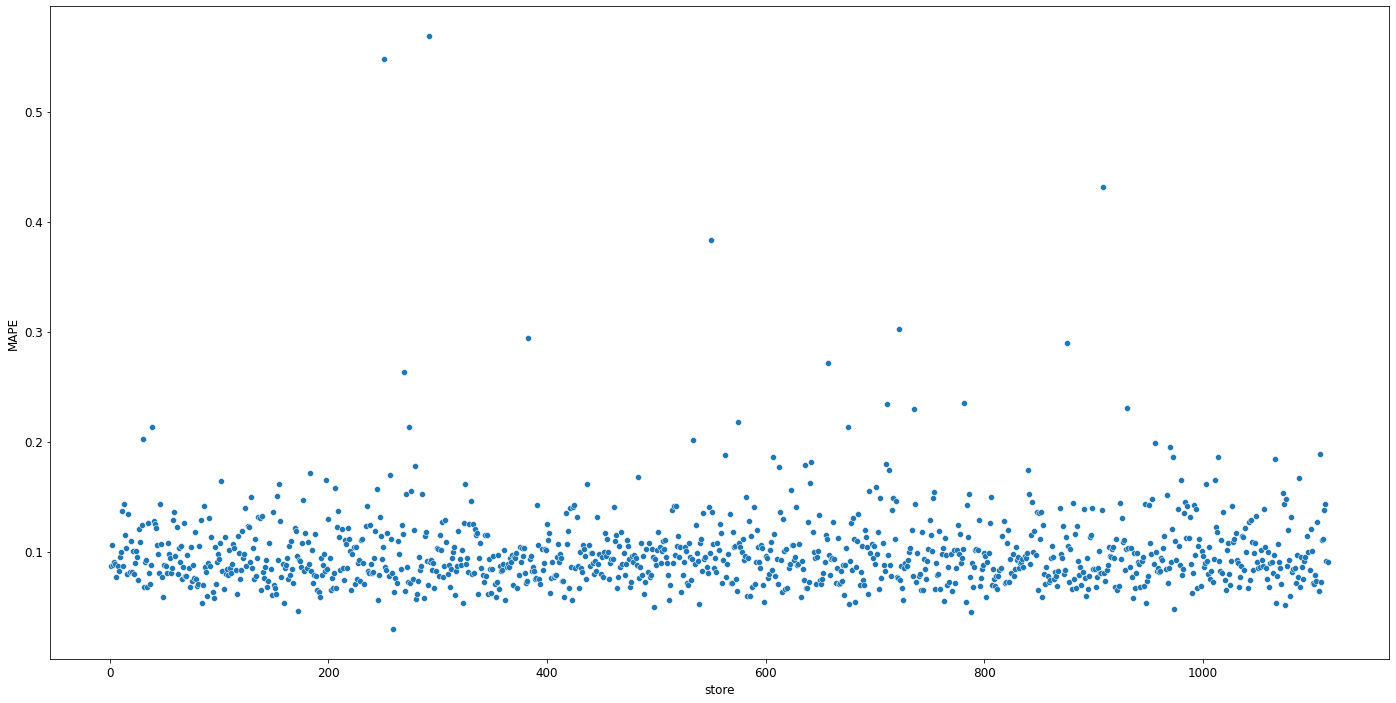

In [69]:
# configurando o gráfico
_, ax = plt.subplots(nrows=1, ncols=1)

# plotagem
sns.scatterplot(x='store', y='MAPE', data=df_resultado, ax=ax);

In [70]:
# calculando o erro bruto por loja e a taxa de erro
df_resultado_completo['error'] = df_resultado_completo['sales'] - df_resultado_completo['predictions']
df_resultado_completo['error_rate'] = df_resultado_completo['predictions'] / df_resultado_completo['sales']

# checando
df_resultado_completo.head(3)

,assortment,competition_distance,promo,store,competition_time_month,competition_open_since_month,competition_open_since_year,day_of_week_sin,day_of_week_cos,promo2_since_week,promo2_since_year,date,sales,predictions,error,error_rate
0,1,-0.177,1,1,0.932,9,2008,-0.975,-0.223,31,2015,2015-07-31,5263,4638.462,624.538,0.881
1,1,-0.286,1,2,1.068,11,2007,-0.975,-0.223,13,2010,2015-07-31,6064,5397.271,666.729,0.890
2,1,1.823,1,3,1.219,12,2006,-0.975,-0.223,14,2011,2015-07-31,8314,8223.566,90.434,0.989


c:\Users\gbrce\Desktop\rossmann-previsao-de-vendas\venv-rossmann\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


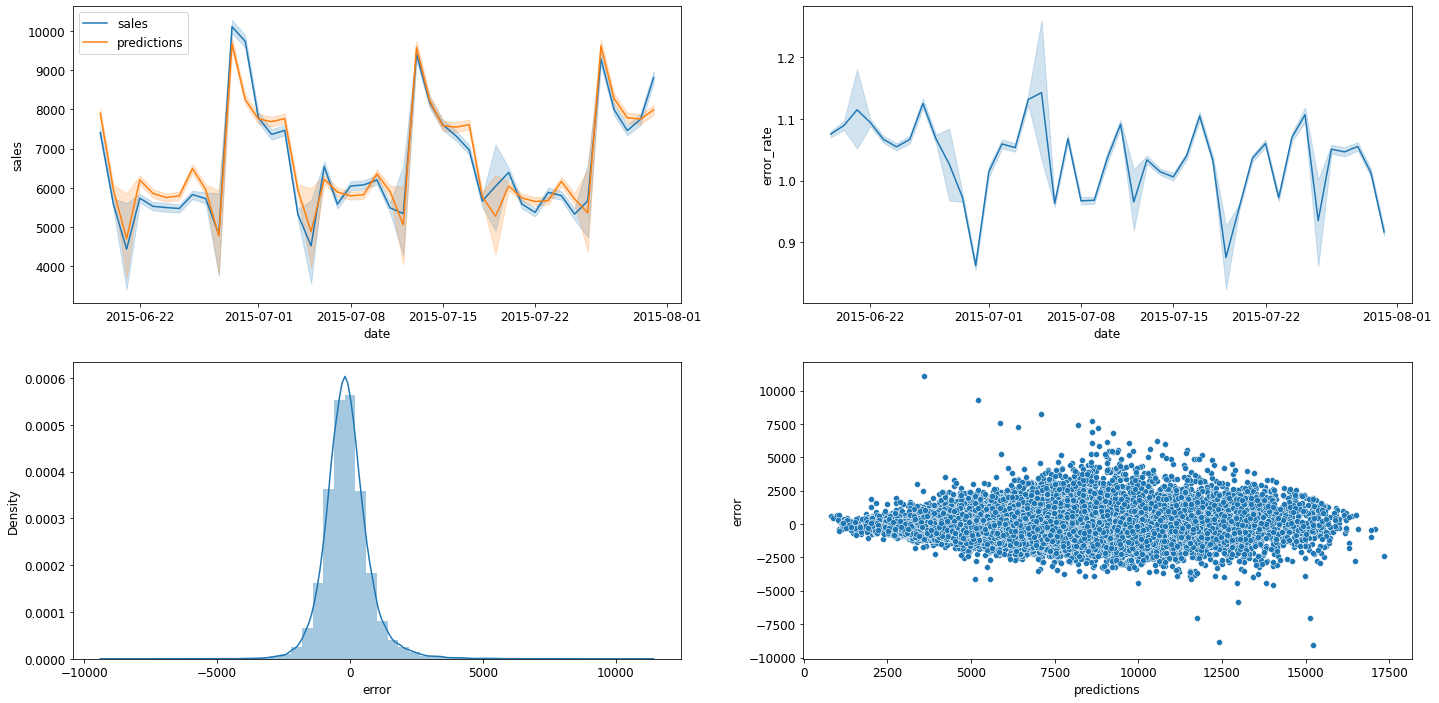

In [71]:
# configurando o gráfico
_, ax = plt.subplots(nrows=2, ncols=2)
(ax1, ax2), (ax3, ax4) = ax

# plotagem
## primeira linha
sns.lineplot(x='date', y='sales', data=df_resultado_completo, ax=ax1, label='sales');
sns.lineplot(x='date', y='predictions', data=df_resultado_completo, ax=ax1, label='predictions');
sns.lineplot(x='date', y='error_rate', data=df_resultado_completo, ax=ax2);

## segunda linha
sns.distplot(df_resultado_completo['error'], ax=ax3);
sns.scatterplot(x='predictions', y='error', data=df_resultado_completo, ax=ax4);

# 8. Deploy

## 8.1. API Class

In [172]:
class RossmannPipeline(object):
    def __init__(self):
        # definindo variável com o caminho padrão do projeto
        self.home_path = os.getcwd().replace('\\src\\api', '')
        
        # carregando o modelo
        self.model = joblib.load(self.home_path + '\\models\\modelo.pkl')
        
        # carregando parâmetros de pré-processamento
        ## minmax
        self.mms_promo_time_week = joblib.load(self.home_path + '\\parameters\\mms_promo_time_week.pkl')
        self.mms_year = joblib.load(self.home_path + '\\parameters\\mms_year.pkl')
        
        # robust
        self.rs_competition_distance = joblib.load(self.home_path + '\\parameters\\rs_competition_distance.pkl')
        self.rs_competition_time_month = joblib.load(self.home_path + '\\parameters\\rs_competition_time_month.pkl')


    def data_cleaning(self, df):
        # renomeando as colunas
        df.columns = [underscore(coluna) for coluna in df.columns]
        
        # tipo dos dados
        colunas_para_category = ['store', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'promo2']
        df[colunas_para_category]= df[colunas_para_category].apply(lambda coluna: coluna.astype('category'))
        df['date'] = pd.to_datetime(df['date'])

        # dados faltantes
        df['competition_distance'] = df['competition_distance'].apply(lambda x: 200_000.0 if pd.isna(x) else x)
        df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        df['promo2_since_week'] = df.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        df['promo2_since_year'] = df.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        df['promo_interval'].fillna(0, inplace=True)
        dic_month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df['month_map'] = df['date'].dt.month.map(dic_month_map)
        df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        colunas_para_int = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']
        df[colunas_para_int]= df[colunas_para_int].apply(lambda coluna: coluna.astype('int64'))
        
        return df
    
    
    def feature_engineering(self, df):
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['week_of_year'] = df['date'].dt.weekofyear
        df['year_week'] = df['date'].dt.strftime('%Y-%W')
        
        df['competition_since'] = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df['competition_time_month'] = ((df['date'] - df['competition_since']) / 30).apply(lambda x: x.days).astype('int64')
        df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
        df['promo_since'] = df['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df['promo_time_week'] = ((df['date'] - df['promo_since']) / 7).apply(lambda x: x.days).astype('int64')
        
        df['assortment'] = df['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
        df['state_holiday'] = df['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c'else 'regular_day')

        colunas_dropar = ['open', 'promo_interval', 'month_map']
        df.drop(colunas_dropar, axis=1, inplace=True)
        
        return df
    
    
    def data_preprocessing(self, df):
        # min max        
        df.loc[:, 'promo_time_week'] = self.mms_promo_time_week.transform(df[['promo_time_week']])
        df.loc[:, 'year'] = self.mms_year.transform(df[['year']])
        
        # robust
        df.loc[:, 'competition_distance'] = self.rs_competition_distance.transform(df[['competition_distance']])
        df.loc[:, 'competition_time_month'] = self.rs_competition_time_month.transform(df[['competition_time_month']])
        
        # one-hot
        df = pd.get_dummies(df, columns=['state_holiday', 'store_type'])

        # ordinal
        df['assortment'] = df['assortment'].map({'basic': 1, 'extra': 2, 'extended': 3})

        # sin and cosine
        df['month_sin'] = df['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df['month_cos'] = df['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
        df['day_sin'] = df['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df['day_cos'] = df['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
        df['week_of_year_sin'] = df['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df['week_of_year_cos'] = df['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        df['day_of_week_sin'] = df['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df['day_of_week_cos'] = df['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
        
        # feature selection
        colunas_finais = ['assortment', 'competition_distance', 'promo', 'store', 'competition_time_month',
                          'competition_open_since_month', 'competition_open_since_year', 'day_of_week_sin',
                          'day_of_week_cos', 'promo2_since_week', 'promo2_since_year']
        
        return df.loc[:, colunas_finais]
    
    
    def get_prediction(self, model, original_data, test_data):
        # predict
        y_hat = model.predict(test_data)

        # prediction column
        original_data['prediction'] = y_hat

        return original_data.to_json(orient='records', date_format='iso')

## 8.2. API handler

In [ ]:
# importando bibliotecas
from flask import Flask, request, Response
from api.rossmann import RossmannPipeline

# carregando em memória o modelo serializado
modelo = joblib.load('..\..\models\modelo.pkl')

# instanaciando a variável com o app do flask
app = Flask(__name__)

# definindo o endpoint das predições
@app.route('/rossmann/predict', methods=['POST'])

# definindo a função preditora
def rossmann_predict():
    teste_json = request.get_json()

    if teste_json: # se houver dados
        if isinstance(teste_json, dict): # exemplo único
            df_raw = pd.DataFrame(teste_json, index=[0])
        else: # múltiplos exemplos
            df_raw = pd.DataFrame(teste_json, columns=teste_json[0].keys())
        
        # instanciando a classe que contém todo o pipeline realizado do projeto
        pipeline = RossmannPipeline()

        # data cleaning
        df1 = pipeline.data_cleaning(df_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preprocessing
        df3 = pipeline.data_preprocessing(df2)

        # predição
        df_response = pipeline.get_prediction(modelo, df_raw, df3)

        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run(host='192.168.0.17', port=5000, debug=True)

## 8.3. API teste

In [96]:
# lendo os dados de teste disponibilizados no kaggle
df_raw_teste = pd.read_csv('../data/raw/test.csv', low_memory=False)

# juntando o conjunto de teste com as informações das lojas
df_teste = pd.merge(df_raw_teste, df_raw_lojas, how='left', on='Store')

# selecionando apenas uma loja (22) para teste
df_teste = df_teste[df_teste['Store'] == 22]

# filtrando para apenas os dias que a farmácia esteve aberta
df_teste = df_teste[df_teste['Open'] != 0]
df_teste = df_teste[~df_teste['Open'].isna()]
df_teste.drop('Id', axis=1, inplace=True)

In [124]:
import requests
import json

# convertendo os dados para o formato json
data = json.dumps(df_teste.to_dict(orient='records'))

# chamando a API
# url = 'http://192.168.0.17:5000/rossmann/predict'
url = 'https://rossmann-projeto.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

# criando a request
r = requests.post(url=url, data=data, headers=header)
print(f'Status code: {r.status_code}')

Status code: 200


In [125]:
# testando o modelo com os dados de teste 
dado1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
dado1[['store', 'prediction']].groupby('store').sum().reset_index()

,store,prediction
0,22,187700.988
